In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from pylab import rcParams
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import select_coint_rank

from sklearn.metrics import mean_squared_error

# Reading Data

In [2]:
# Data Reading
train = pd.read_csv('Dataset/train.csv')
store = pd.read_csv('Dataset/store.csv')

# EDA

In [3]:
# Checking sample data for train
train.head().append(train.tail())

# Data present from 2013-01-01 to 2015-07-31

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [4]:
#Checking train data size
train.shape

(1017209, 9)

In [5]:
#Checking data types of columns and null analysis
train.info()

# All data points are non-null and therefore do not require any imputation or further analysis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [6]:
#Checking the spread of numerical columns for train
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [7]:
# Checking sample data for store
store.head().append(store.tail())

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1114,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [8]:
#Checking store data size
store.shape

(1115, 10)

In [9]:
#Checking data types of columns and null analysis
store.info()

#Store data has null values, we will need to impute them

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [10]:
# Checking % counts of null values
100*store.isnull().sum()/store.shape[0]

Store                         0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.269058
CompetitionOpenSinceMonth    31.748879
CompetitionOpenSinceYear     31.748879
Promo2                        0.000000
Promo2SinceWeek              48.789238
Promo2SinceYear              48.789238
PromoInterval                48.789238
dtype: float64

In [11]:
#Absence of promo values would mean that there are no promotions running on the store, we can impute that with zero
store['Promo2SinceWeek'].fillna(0, inplace=True)
store['Promo2SinceYear'].fillna(0, inplace=True)
store['PromoInterval'].fillna(0, inplace=True)

In [12]:
# Competition distance have only 3 null values
store[store.CompetitionDistance.isna()]

# Corresponding value for CompetitionOpenSinceMonth and CompetitionOpenSinceYear are NaN, so that mean no competition exists
# So filling those values with 0

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,0.0,0.0,0
621,622,a,c,NaN,NaN,NaN,0,0.0,0.0,0
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [13]:
# Fill CompetitionDistance with 0
store['CompetitionDistance'].fillna(0, inplace=True)

In [14]:
# Checking % counts of null values again
100*store.isnull().sum()/store.shape[0]

#CompetitionOpenSinceMonth and CompetitionOpenSinceYear has null values, we will handle them later after further analysis.

Store                         0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.000000
CompetitionOpenSinceMonth    31.748879
CompetitionOpenSinceYear     31.748879
Promo2                        0.000000
Promo2SinceWeek               0.000000
Promo2SinceYear               0.000000
PromoInterval                 0.000000
dtype: float64

# Data Analysis

In [15]:
# Creating function for plots

def CountPlot(features,df):
    cols=4
    rows = len(features)//cols +1
    fig = plt.figure(figsize=(16, rows*5))
    dataframe = df.copy()
    for plot, feature in enumerate(features):
        fig.add_subplot(rows,cols,plot+1)
        fig.tight_layout(h_pad=5, w_pad=5)
        # Fill NA values with 'Missing'
        dataframe[feature] = dataframe[feature].fillna('Missing')
        # Plot sns countplot
        ax = sns.countplot(x=feature, data=dataframe, order=dataframe[feature].value_counts().index)
        plt.xticks(rotation = 90)
        plt.title("for {}".format(feature))
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2., height + 3, '{:1.2f}'.format(height/len(dataframe) * 100), ha="center")

### Univariate Data Analysis on datasets

#### For Store Data

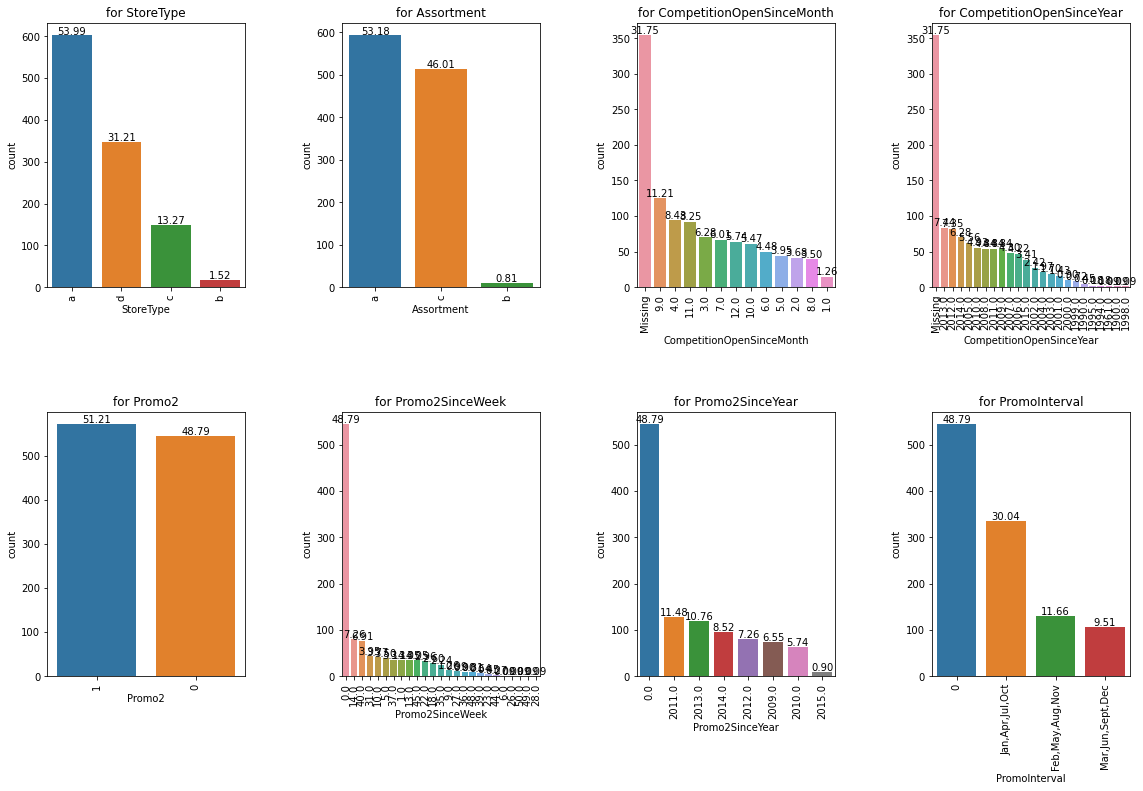

In [16]:
# Store Data categorical fields
store_categorical_fields=['StoreType','Assortment','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2','Promo2SinceWeek','Promo2SinceYear','PromoInterval']

# Count plots for store data
CountPlot(store_categorical_fields,store)

### Inferences on store data

* Majority of the stores, almost 54% are type A stores.
* Majority of the stores have type A of the assortments, other type of assortments are low.
* Data for Competition is Null for 31% of the stores, meaning there is either no competition for those stores or the data is missing.
* 48% of the stores do not have promotions; Promo2 in the store.
* Promotions are concentrated in months of Jan, Apr, Jul, Oct months.

#### For Train Data

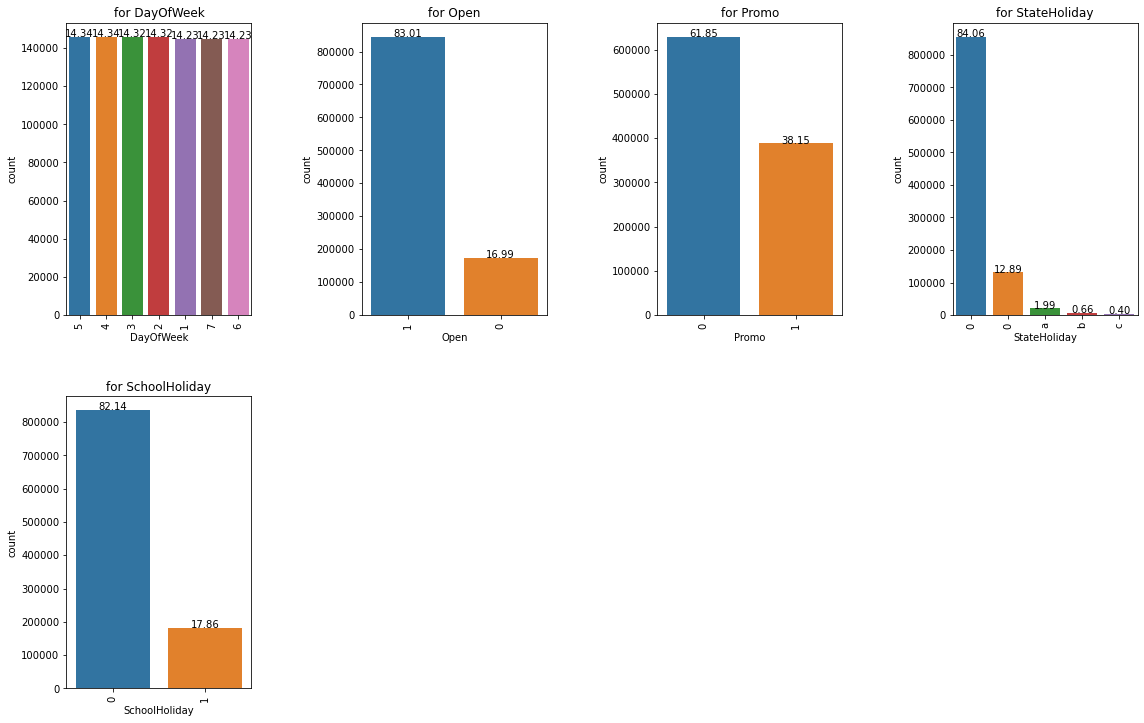

In [17]:
# Train Data categoric variables
train_categorical_fields=['DayOfWeek','Open', 'Promo', 'StateHoliday', 'SchoolHoliday']
# Count plots for store data
CountPlot(train_categorical_fields,train)

### Inferences on train data
* All days of the week have equal contribution.
* Stores are closed on only 17% data points.
* Promotions are active on only 38% records.

## Box plot and outlier analysis on datasets

### For store data

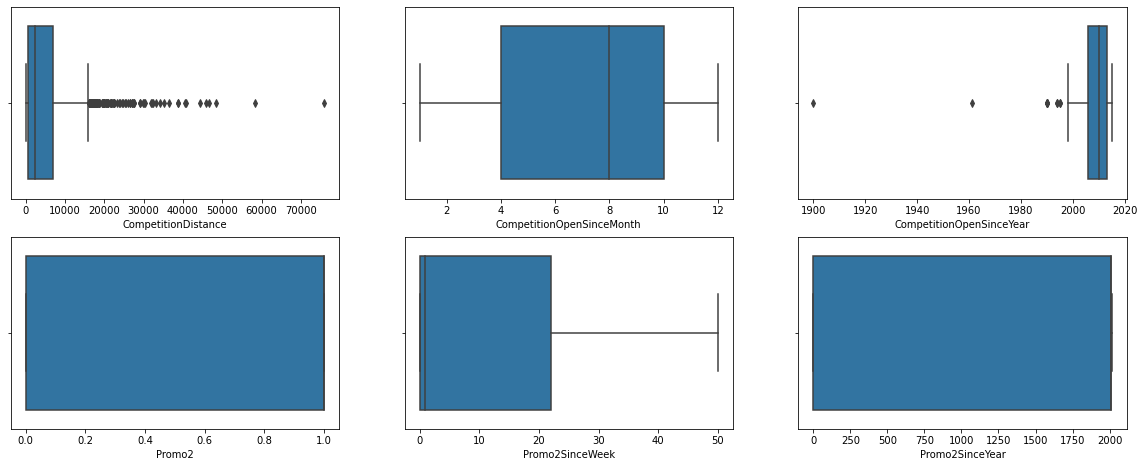

In [18]:
plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(x = 'CompetitionDistance', data = store)
plt.subplot(3,3,2)
sns.boxplot(x = 'CompetitionOpenSinceMonth', data = store)
plt.subplot(3,3,3)
sns.boxplot(x = 'CompetitionOpenSinceYear',data = store)
plt.subplot(3,3,4)
sns.boxplot(x = 'Promo2', data = store)
plt.subplot(3,3,5)
sns.boxplot(x = 'Promo2SinceWeek', data = store)
plt.subplot(3,3,6)
sns.boxplot(x = 'Promo2SinceYear', data = store)
plt.show()

* From the boxplots,we can see outliers in CompetitionDistance and CompetitionOpenSinceYear attributes. We will need to analyze them
* For Competition distance, we would not need the values higher than the 99th percentile. We can cap the values having higher than 99th %ile to 99th %ile

In [19]:
# Capping values of CompetitionDistance to 99th %ile
# store.CompetitionDistance.quantile(.99) = 35107.80

store.loc[store.CompetitionDistance>store.CompetitionDistance.quantile(.99),'CompetitionDistance']=store.CompetitionDistance.quantile(.99)

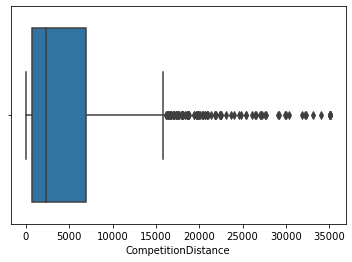

In [20]:
sns.boxplot(x = 'CompetitionDistance', data = store)
plt.show()

# The distance values seem to be in considerable range now.

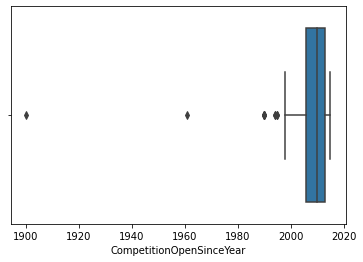

In [21]:
# Checking for CompetitionOpenSinceYear
sns.boxplot(x = 'CompetitionOpenSinceYear',data = store)
plt.show()

In [22]:
store['CompetitionOpenSinceYear'].isnull().sum()

354

In [23]:
store['CompetitionOpenSinceMonth'].isnull().sum()

354

In [24]:
store[store['CompetitionOpenSinceMonth'].isnull() & store['CompetitionOpenSinceYear'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,0.0,0.0,0
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,0.0,0.0,0
1113,1114,a,c,870.0,NaN,NaN,0,0.0,0.0,0


In [25]:
# No data is available for competition store openings, let's impute them with zero
store.CompetitionOpenSinceYear.fillna(0,inplace=True)
store.CompetitionOpenSinceMonth.fillna(0,inplace=True)

In [26]:
# Checking null values
100*store.isnull().sum()/store.shape[0]

Store                        0.0
StoreType                    0.0
Assortment                   0.0
CompetitionDistance          0.0
CompetitionOpenSinceMonth    0.0
CompetitionOpenSinceYear     0.0
Promo2                       0.0
Promo2SinceWeek              0.0
Promo2SinceYear              0.0
PromoInterval                0.0
dtype: float64

# Merging the datasets

In [27]:
train_df = train.merge(right=store, on='Store', how='inner')
train_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,6,2013-01-05,4771,339,1,0,0,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017205,1115,5,2013-01-04,4540,326,1,0,0,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017206,1115,4,2013-01-03,4297,300,1,0,0,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017207,1115,3,2013-01-02,3697,305,1,0,0,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [28]:
#Checking shape of the merged dataset
train_df.shape

(1017209, 18)

In [29]:
#Numerical descriptions
train_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,5.297227e+03,4.926878e+00,1.370173e+03,5.005638e-01,1.164767e+01,1.007011e+03
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,7.056706e+03,4.283543e+00,9.353634e+02,4.999999e-01,1.532393e+01,1.005877e+03
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,7.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.320000e+03,4.000000e+00,2.006000e+03,1.000000e+00,1.000000e+00,2.009000e+03
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,6.880000e+03,9.000000e+00,2.011000e+03,1.000000e+00,2.200000e+01,2.012000e+03
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,3.510780e+04,1.200000e+01,2.015000e+03,1.000000e+00,5.000000e+01,2.015000e+03


In [30]:
# Checking percentage of null records
100*train_df.isnull().sum()/train_df.shape[0]

# We do not have any null values in the data

Store                        0.0
DayOfWeek                    0.0
Date                         0.0
Sales                        0.0
Customers                    0.0
Open                         0.0
Promo                        0.0
StateHoliday                 0.0
SchoolHoliday                0.0
StoreType                    0.0
Assortment                   0.0
CompetitionDistance          0.0
CompetitionOpenSinceMonth    0.0
CompetitionOpenSinceYear     0.0
Promo2                       0.0
Promo2SinceWeek              0.0
Promo2SinceYear              0.0
PromoInterval                0.0
dtype: float64

## Bivariate Analysis on Data

### Box Plot Analysis

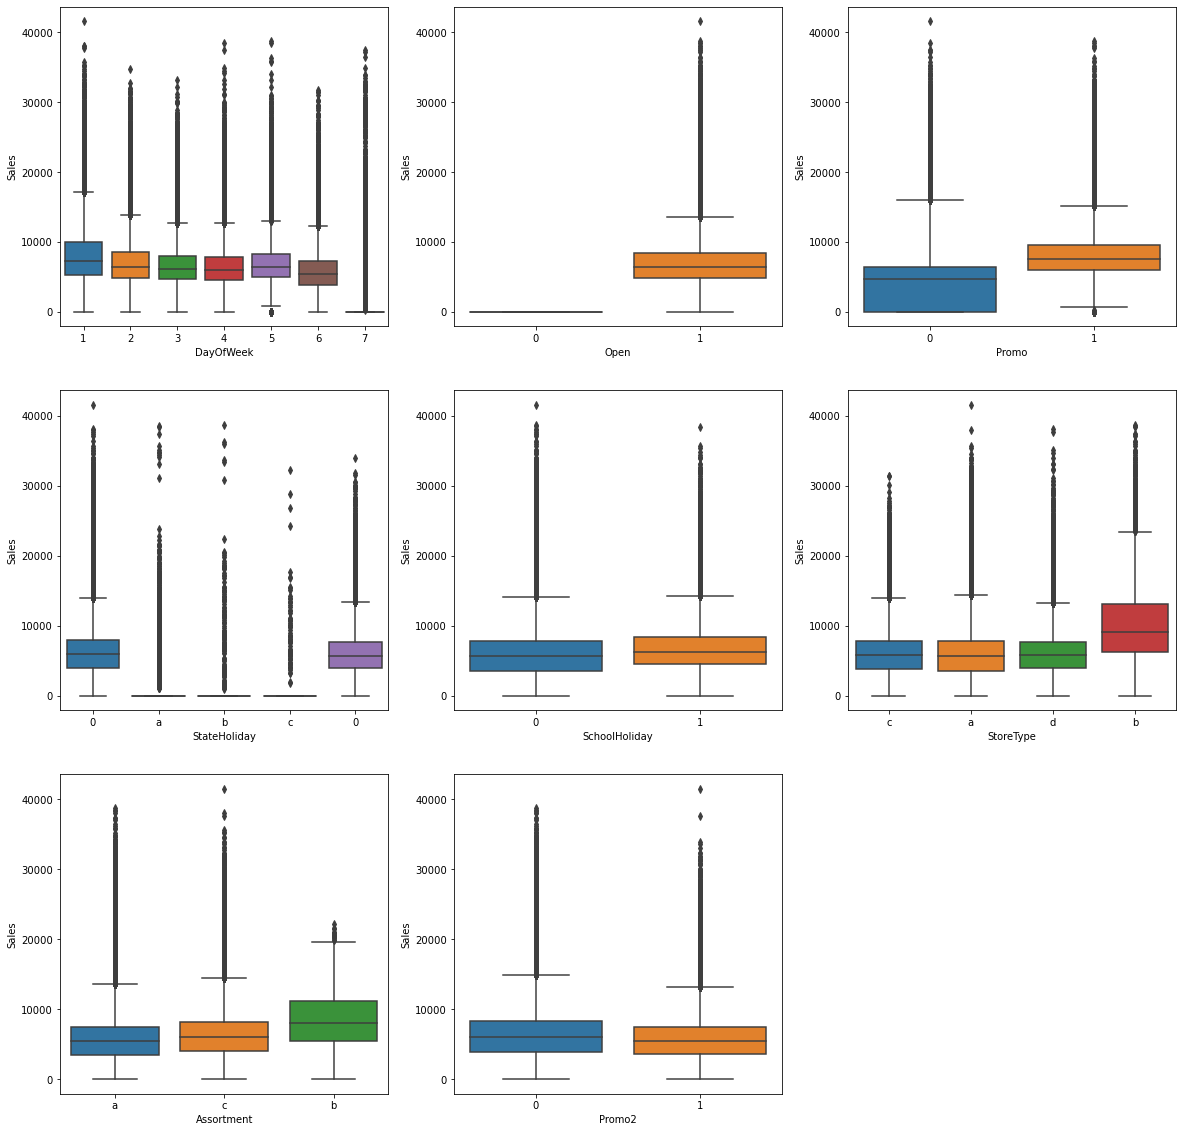

In [31]:
# Boxplots of attributes against Sales

plt.figure(figsize=(20, 20))
plt.subplot(3,3,1)
sns.boxplot(x = 'DayOfWeek', y = 'Sales', data = train_df)
plt.subplot(3,3,2)
sns.boxplot(x = 'Open', y = 'Sales', data = train_df)
plt.subplot(3,3,3)
sns.boxplot(x = 'Promo', y = 'Sales', data = train_df)
plt.subplot(3,3,4)
sns.boxplot(x = 'StateHoliday', y = 'Sales', data = train_df)
plt.subplot(3,3,5)
sns.boxplot(x = 'SchoolHoliday', y = 'Sales', data = train_df)
plt.subplot(3,3,6)
sns.boxplot(x = 'StoreType', y = 'Sales', data = train_df)
plt.subplot(3,3,7)
sns.boxplot(x = 'Assortment', y = 'Sales', data = train_df)
plt.subplot(3,3,8)
sns.boxplot(x = 'Promo2', y = 'Sales', data = train_df)
plt.show()

### Inferences on merged Data
* Sales are higher on 1st, 2nd and 5th weekdays. Sales are very low on 7th weekday.
* Sales are higher when promotion is 1
* On state holidays, a, b and c, sales are low
* School holidays do not seem to impact sales
* Store type B has higher % of sales than other store types
* Assortment type B has higher sales
#### Promo2 does not seem to have much contribution to sales

### Scatter Plot Analysis

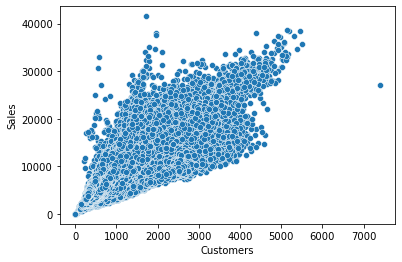

In [32]:
# scatterplots of Customers against Sales
sns.scatterplot(x = 'Customers', y = 'Sales', data = train_df)
plt.show()

# Increase in no. of customers correlates an increase in sales

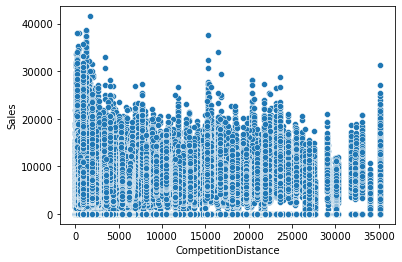

In [33]:
# scatterplots of Customers against Sales
sns.scatterplot(x = 'CompetitionDistance', y = 'Sales', data = train_df)
plt.show()

# Competition does not seem to have any correlations against sales

## Multivariate Analysis

### For categorical variables

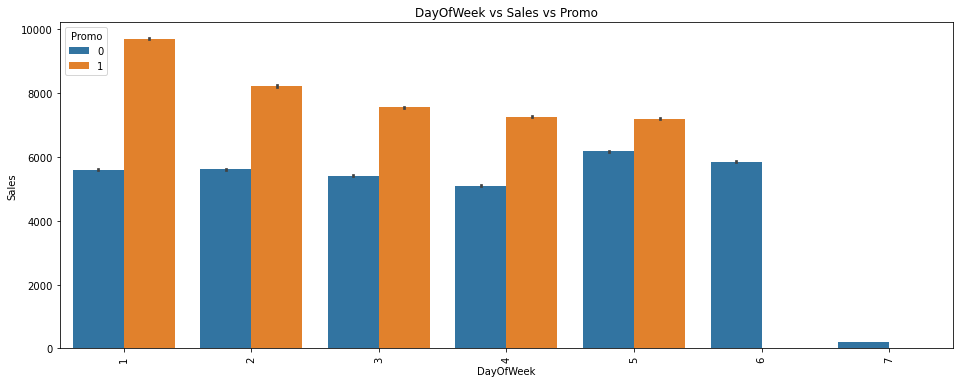

In [34]:
# Checking co-relation between Sales vs Days vs Promo
plt.figure(figsize=(16, 6))
sns.barplot(x='DayOfWeek', y='Sales', hue='Promo', data=train_df)
plt.title("DayOfWeek vs Sales vs Promo")
plt.xticks(rotation = 90)
plt.show()

* Promotion has a strong co-relation with sales of the stores.

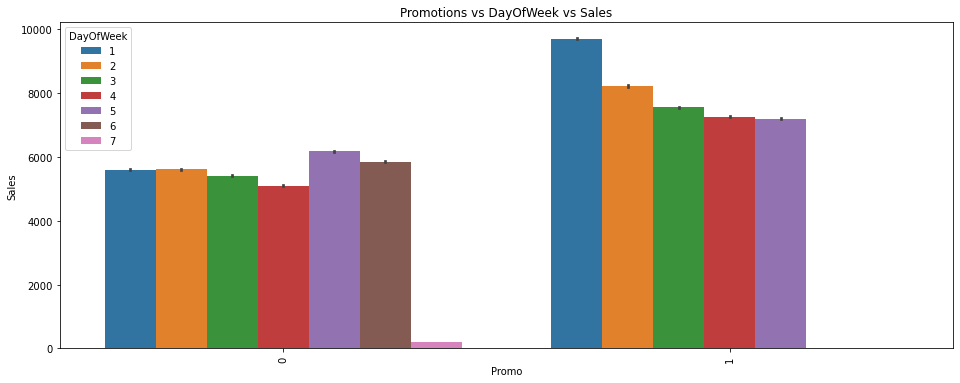

In [35]:
# Checking co-relation between Promo vs Days
plt.figure(figsize=(16, 6))
sns.barplot(x='Promo', y='Sales', hue='DayOfWeek', data=train_df)
plt.title("Promotions vs DayOfWeek vs Sales")
plt.xticks(rotation = 90)
plt.show()

* Days at the start of the week are higher Sales than sales of other days when Promo=1

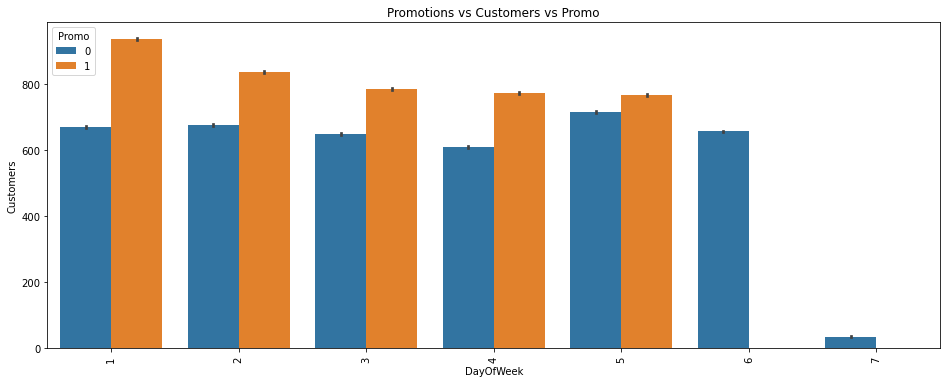

In [36]:
# Checking co-relation between Days vs Customers vs Promo 
plt.figure(figsize=(16, 6))
sns.barplot(x='DayOfWeek', y='Customers', hue='Promo', data=train_df)
plt.title("Promotions vs Customers vs Promo")
plt.xticks(rotation = 90)
plt.show()

* Customers are higher on weekdays and when promotios are active

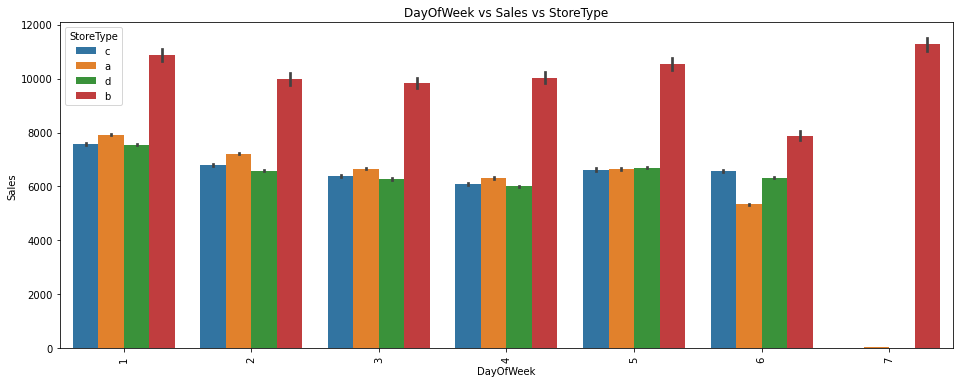

In [37]:
# Checking co-relation between Days vs Sales vs StoreType 
plt.figure(figsize=(16, 6))
sns.barplot(x='DayOfWeek', y='Sales', hue='StoreType', data=train_df)
plt.title("DayOfWeek vs Sales vs StoreType")
plt.xticks(rotation = 90)
plt.show()

* Sales for store type b is the highest among all days including day 7 where sales for other store type is almost zero. 
* On day 6, the difference in sales among store type is marginally lower than other days

### For numerical variables

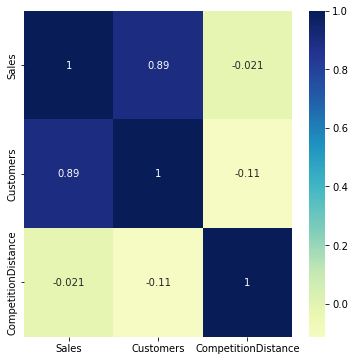

In [38]:
# Checking co-relation coefficients for numerical variables

# plot heat map for corr
cor = train_df[['Sales','Customers','CompetitionDistance']].corr()
plt.figure(figsize = (6, 6))
sns.heatmap(cor, annot = True,center=0.4,cmap="YlGnBu")
plt.show()

* Sales and customer have a very strong co-relation with a factor of 0.89. For other variables, it is insignificant.

# Feature Engineering

#### Creating dummy variables

In [39]:
# Creating dummy variable for day of the week 
dummies=pd.get_dummies(train_df['DayOfWeek'], drop_first=True, prefix='DayOfWeek')
train_df=pd.concat([train_df, dummies], axis=1)

In [40]:
# Creating dummy variable for StoreType 
dummies=pd.get_dummies(train_df['StoreType'], drop_first=True, prefix='StoreType')
train_df=pd.concat([train_df, dummies], axis=1)

In [41]:
# Creating dummy variable for Assortment 
dummies=pd.get_dummies(train_df['Assortment'], drop_first=True, prefix='Assortment')
train_df=pd.concat([train_df, dummies],axis=1)

In [42]:
# Viewing data
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,0,0,1,0,0,0,1,0,0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,...,0,1,0,0,0,0,1,0,0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,...,1,0,0,0,0,0,1,0,0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,...,0,0,0,0,0,0,1,0,0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,...,0,0,0,0,0,0,1,0,0,0


In [43]:
# Dropping DayOfWeek, StoreType and Assortment
#train_df.drop(['DayOfWeek','StoreType','Assortment'],axis=1,inplace=True)
#train_df.head()

In [44]:
# For competition data, we can merge their date information into a single column
train_df['CompetitionOpenSince'] = train_df.CompetitionOpenSinceYear.astype(int).astype(str) + '-' + train_df.CompetitionOpenSinceMonth.astype(int).astype(str) + '-01'
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c,CompetitionOpenSince
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,0,1,0,0,0,1,0,0,0,2008-9-01
1,1,4,2015-07-30,5020,546,1,1,0,1,c,...,1,0,0,0,0,1,0,0,0,2008-9-01
2,1,3,2015-07-29,4782,523,1,1,0,1,c,...,0,0,0,0,0,1,0,0,0,2008-9-01
3,1,2,2015-07-28,5011,560,1,1,0,1,c,...,0,0,0,0,0,1,0,0,0,2008-9-01
4,1,1,2015-07-27,6102,612,1,1,0,1,c,...,0,0,0,0,0,1,0,0,0,2008-9-01


In [45]:
# Dropping CompetitionOpenSinceMonth, CompetitionOpenSinceYear fields
train_df.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear'], axis=1, inplace=True)

In [46]:
# We had 354 stores where competion opening dates were not available, the dates for CompetitionOpenSince for those stores needs to be impute with null
train_df.loc[train_df.CompetitionOpenSince=='0-0-01','CompetitionOpenSince']

10362      0-0-01
10363      0-0-01
10364      0-0-01
10365      0-0-01
10366      0-0-01
            ...  
1017204    0-0-01
1017205    0-0-01
1017206    0-0-01
1017207    0-0-01
1017208    0-0-01
Name: CompetitionOpenSince, Length: 323348, dtype: object

In [47]:
#Imputing them with null
train_df.loc[train_df.CompetitionOpenSince=='0-0-01','CompetitionOpenSince']=np.nan

In [48]:
#Checking datatypes
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 28 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Store                 1017209 non-null  int64  
 1   DayOfWeek             1017209 non-null  int64  
 2   Date                  1017209 non-null  object 
 3   Sales                 1017209 non-null  int64  
 4   Customers             1017209 non-null  int64  
 5   Open                  1017209 non-null  int64  
 6   Promo                 1017209 non-null  int64  
 7   StateHoliday          1017209 non-null  object 
 8   SchoolHoliday         1017209 non-null  int64  
 9   StoreType             1017209 non-null  object 
 10  Assortment            1017209 non-null  object 
 11  CompetitionDistance   1017209 non-null  float64
 12  Promo2                1017209 non-null  int64  
 13  Promo2SinceWeek       1017209 non-null  float64
 14  Promo2SinceYear       1017209 non-

In [49]:
# Date and CompetitionOpenSince are date objects, we need convert them into datetime objects

#Converting date field to datetime object
train_df['Date']=pd.to_datetime(train_df['Date'], errors='coerce')

#Converting CompetitionOpenSince field to datetime object
train_df['CompetitionOpenSince']=pd.to_datetime(train_df['CompetitionOpenSince'], errors='coerce')

In [50]:
#Checking data types again
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 28 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   Store                 1017209 non-null  int64         
 1   DayOfWeek             1017209 non-null  int64         
 2   Date                  1017209 non-null  datetime64[ns]
 3   Sales                 1017209 non-null  int64         
 4   Customers             1017209 non-null  int64         
 5   Open                  1017209 non-null  int64         
 6   Promo                 1017209 non-null  int64         
 7   StateHoliday          1017209 non-null  object        
 8   SchoolHoliday         1017209 non-null  int64         
 9   StoreType             1017209 non-null  object        
 10  Assortment            1017209 non-null  object        
 11  CompetitionDistance   1017209 non-null  float64       
 12  Promo2                1017209 non-null  in

#### There will be store transaction dates where sales were made before competition started and sales after competition.

In [51]:
# Let's create a new flag for their identification
def calculate_competition(row):
    if row.CompetitionOpenSince > row.Date:
        return 1
    else:
        return 0

train_df['Row_Date_Before_CompetitionOpenSince']=train_df[['CompetitionOpenSince','Date']].apply(calculate_competition,axis=1)

In [52]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c,CompetitionOpenSince,Row_Date_Before_CompetitionOpenSince
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,1,0,0,0,1,0,0,0,2008-09-01,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,...,0,0,0,0,1,0,0,0,2008-09-01,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,...,0,0,0,0,1,0,0,0,2008-09-01,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,...,0,0,0,0,1,0,0,0,2008-09-01,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,...,0,0,0,0,1,0,0,0,2008-09-01,0


In [53]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 29 columns):
 #   Column                                Non-Null Count    Dtype         
---  ------                                --------------    -----         
 0   Store                                 1017209 non-null  int64         
 1   DayOfWeek                             1017209 non-null  int64         
 2   Date                                  1017209 non-null  datetime64[ns]
 3   Sales                                 1017209 non-null  int64         
 4   Customers                             1017209 non-null  int64         
 5   Open                                  1017209 non-null  int64         
 6   Promo                                 1017209 non-null  int64         
 7   StateHoliday                          1017209 non-null  object        
 8   SchoolHoliday                         1017209 non-null  int64         
 9   StoreType                             1017209 

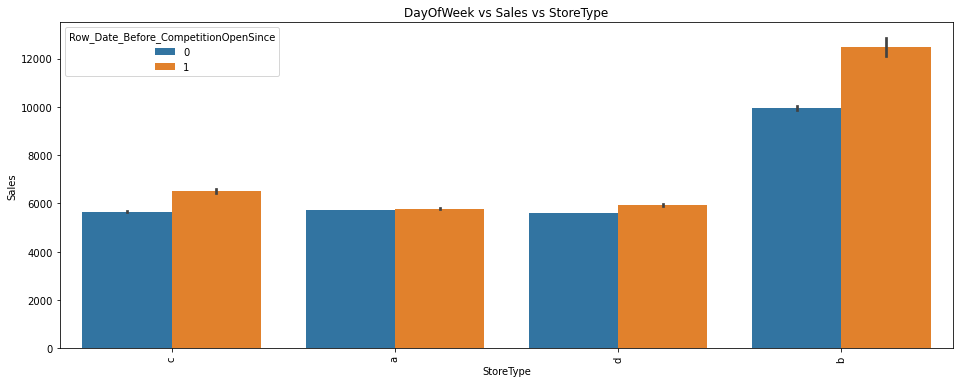

In [54]:
# Checking co-relation between StoreType vs Sales vs Row_Date_Before_CompetitionOpenSince

plt.figure(figsize=(16, 6))
sns.barplot(x='StoreType', y='Sales', hue='Row_Date_Before_CompetitionOpenSince', data=train_df)
plt.title("DayOfWeek vs Sales vs StoreType")
plt.xticks(rotation = 90)
plt.show()

* Sales of stores before and after competition do not have much difference, we can drop this field

In [55]:
train_df.drop(['Row_Date_Before_CompetitionOpenSince'], inplace=True, axis=1)

# We can also drop CompetitionOpenSince, since it is a field for derived Before_Competition
train_df.drop(['CompetitionOpenSince'], inplace=True, axis=1)

In [56]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 27 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   Store                1017209 non-null  int64         
 1   DayOfWeek            1017209 non-null  int64         
 2   Date                 1017209 non-null  datetime64[ns]
 3   Sales                1017209 non-null  int64         
 4   Customers            1017209 non-null  int64         
 5   Open                 1017209 non-null  int64         
 6   Promo                1017209 non-null  int64         
 7   StateHoliday         1017209 non-null  object        
 8   SchoolHoliday        1017209 non-null  int64         
 9   StoreType            1017209 non-null  object        
 10  Assortment           1017209 non-null  object        
 11  CompetitionDistance  1017209 non-null  float64       
 12  Promo2               1017209 non-null  int64         
 1

In [57]:
# We had seen earlier that Promo2 variables does not seem to have much impact on Sales, we can drop them
train_df.drop(['Promo2','Promo2SinceWeek','Promo2SinceYear','Promo2SinceYear'], inplace=True, axis=1)

In [58]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,0,0,1,0,0,0,1,0,0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,...,0,1,0,0,0,0,1,0,0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,...,1,0,0,0,0,0,1,0,0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,...,0,0,0,0,0,0,1,0,0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,...,0,0,0,0,0,0,1,0,0,0


In [59]:
# Dropping DayOfWeek, StoreType and Assortment
train_df.drop(['DayOfWeek','StoreType','Assortment'],axis=1,inplace=True)
train_df.head()

,Store,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,PromoInterval,...,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c
0,1,2015-07-31,5263,555,1,1,0,1,1270.0,0,...,0,0,1,0,0,0,1,0,0,0
1,1,2015-07-30,5020,546,1,1,0,1,1270.0,0,...,0,1,0,0,0,0,1,0,0,0
2,1,2015-07-29,4782,523,1,1,0,1,1270.0,0,...,1,0,0,0,0,0,1,0,0,0
3,1,2015-07-28,5011,560,1,1,0,1,1270.0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,2015-07-27,6102,612,1,1,0,1,1270.0,0,...,0,0,0,0,0,0,1,0,0,0


In [60]:
train_df.columns

Index(['Store', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'CompetitionDistance', 'PromoInterval', 'DayOfWeek_2',
       'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6',
       'DayOfWeek_7', 'StoreType_b', 'StoreType_c', 'StoreType_d',
       'Assortment_b', 'Assortment_c'],
      dtype='object')

# Time Series Analysis

### From our earlier analysis, we have seen that increase in Customers directly translates to increase in Sales meaning customer counts are an endogenous variable for our predictions

In [61]:
#Setting date as index

train_data_df=train_df.set_index('Date')
train_data_df.head(10)

,Store,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,PromoInterval,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c
Date,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5263,555,1,1,0,1,1270.0,0,0,0,0,1,0,0,0,1,0,0,0
2015-07-30,1,5020,546,1,1,0,1,1270.0,0,0,0,1,0,0,0,0,1,0,0,0
2015-07-29,1,4782,523,1,1,0,1,1270.0,0,0,1,0,0,0,0,0,1,0,0,0
2015-07-28,1,5011,560,1,1,0,1,1270.0,0,1,0,0,0,0,0,0,1,0,0,0
2015-07-27,1,6102,612,1,1,0,1,1270.0,0,0,0,0,0,0,0,0,1,0,0,0
2015-07-26,1,0,0,0,0,0,0,1270.0,0,0,0,0,0,0,1,0,1,0,0,0
2015-07-25,1,4364,500,1,0,0,0,1270.0,0,0,0,0,0,1,0,0,1,0,0,0
2015-07-24,1,3706,459,1,0,0,0,1270.0,0,0,0,0,1,0,0,0,1,0,0,0
2015-07-23,1,3769,503,1,0,0,0,1270.0,0,0,0,1,0,0,0,0,1,0,0,0


In [62]:
# Grouping the data at a date level for analysis
train_data_df_all=train_data_df.groupby('Date').agg({'Sales': 'mean', # Mean sales per date for all stores
                                           'Customers':'mean', # Mean customers per date for all stores
                                           'Promo': 'sum', # Sum of Promo for all stores 
                                           'SchoolHoliday':'sum', # Sum of SchoolHoliday for all stores
                                           'DayOfWeek_2':'mean', # Mean for DayOfWeek columns
                                           'DayOfWeek_3':'mean',
                                           'DayOfWeek_4':'mean',
                                           'DayOfWeek_5':'mean',
                                           'DayOfWeek_6':'mean',
                                           'DayOfWeek_7':'mean'})
train_data_df_all.head()

,Sales,Customers,Promo,SchoolHoliday,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
Date,,,,,,,,,,
2013-01-01,87.284560,17.496409,0,1114,1.0,0.0,0.0,0.0,0.0,0.0
2013-01-02,6233.030493,748.049327,0,1115,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-03,5693.112108,682.547085,0,1040,0.0,0.0,1.0,0.0,0.0,0.0
2013-01-04,5954.218834,701.468161,0,1040,0.0,0.0,0.0,1.0,0.0,0.0
2013-01-05,5337.751570,616.566816,0,112,0.0,0.0,0.0,0.0,1.0,0.0


In [63]:
# Creating a function for time series plots
def timeseries_plot(series,c):
    fig = plt.figure(figsize=(20, 3))
    series.plot()
    plt.xlabel('Date')
    plt.ylabel(c)
    plt.title('For {}'.format(c))
    plt.show()

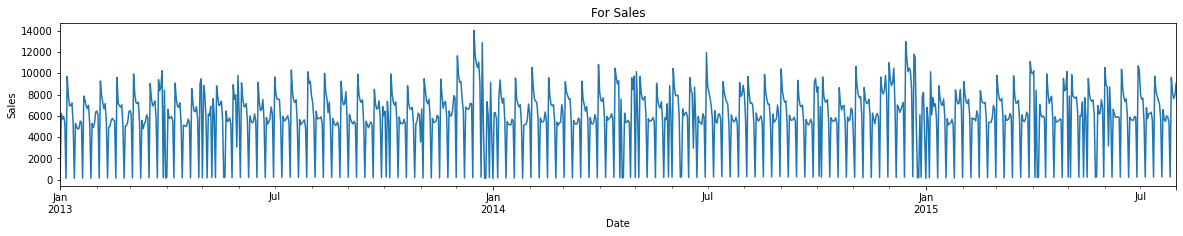

In [64]:
# Plotting time series chart for Sales
timeseries_plot(train_data_df_all['Sales'], 'Sales')

In [65]:
# Creating function for seasonal decomposition
def plot_seasonal_decomposition(series, c, model):
    rcParams['figure.figsize'] = 18, 14
    decomposition = sm.tsa.seasonal_decompose(series, model=model) # additive seasonal index
    fig = decomposition.plot()
    plt.show()
    print('Mean Residual for {}={}'.format(c,decomposition.resid.mean()))

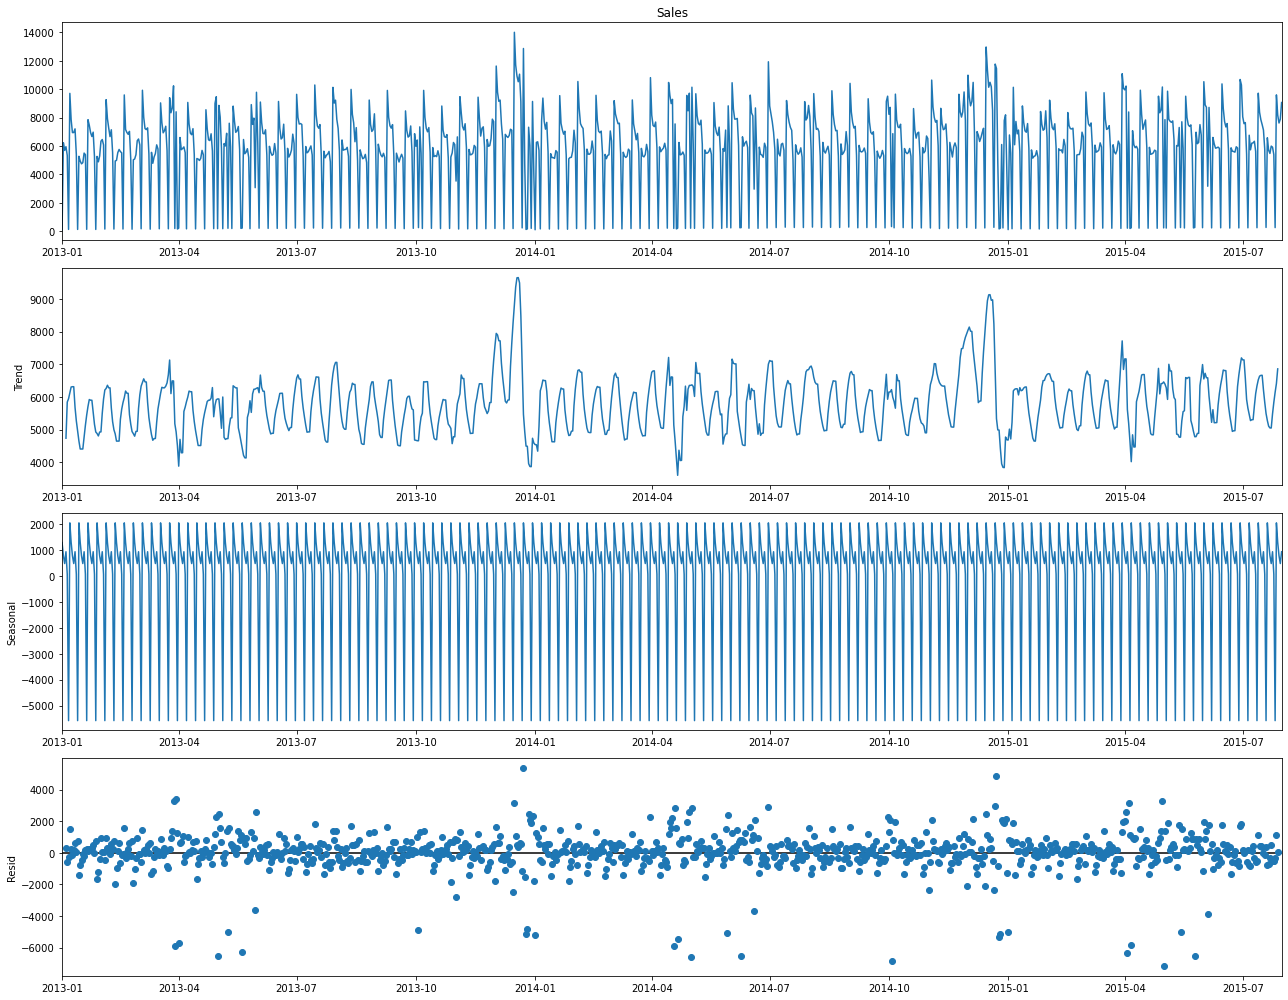

Mean Residual for Sales=0.6202792140320815


In [66]:
plot_seasonal_decomposition(train_data_df_all['Sales'], 'Sales', 'additive')

## Stationary test

In [67]:
# Creating a function for testing stationary using ADF statistic
def stationary_test(df):
    for c in df.columns:
        print('For ',c)
        print('*'*100)
        r=adfuller(df[c], autolag='AIC')
        print('ADF Statistic=',r[0])
        print('P value=',r[1])
        output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
        p_value = output['pvalue']
        if p_value <= 0.05:
            print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
            print(f" => Series is Stationary.")
        else:
            print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
            print(f" => Series is Non-Stationary.")  

In [68]:
stationary_test(train_data_df_all[['Sales','Customers']])

For  Sales
****************************************************************************************************
ADF Statistic= -5.650822837207899
P value= 9.870006549261777e-07
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
For  Customers
****************************************************************************************************
ADF Statistic= -5.933710149589026
P value= 2.3477735379187485e-07
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


* The p-values for both the variables is less than 0.05. We can reject the null hypothesis (which is "The series is not stationary"). -> The series is stationary
* In the dataset, we do not have any other variable which is linearly related to Sales. They do not seem to be time series inputs for our analysis.
### We had earlier determined that since increase in customers relate to increased sales and since no other variable is a time series, we will consider them to be exogenous.

### Autocorelation

In [69]:
#Creating functions for ACF and PACF plots
def plot_acf_pacf(series,c):
    fig = plt.figure(figsize=(20, 3))
    rcParams['figure.figsize'] = 20, 3
    fig.add_subplot(2,1,1)
    plot_acf(series, lags = 75)
    plt.title('ACF for {}'.format(c)) 
    fig.add_subplot(2,2,2)
    plot_pacf(series, lags = 75)
    plt.title('PACF for {}'.format(c)) 
    plt.show()

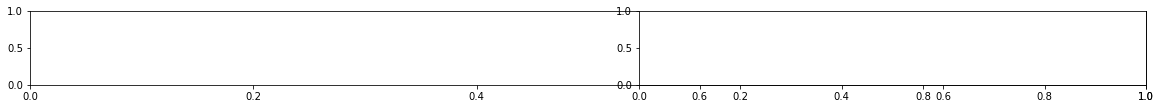

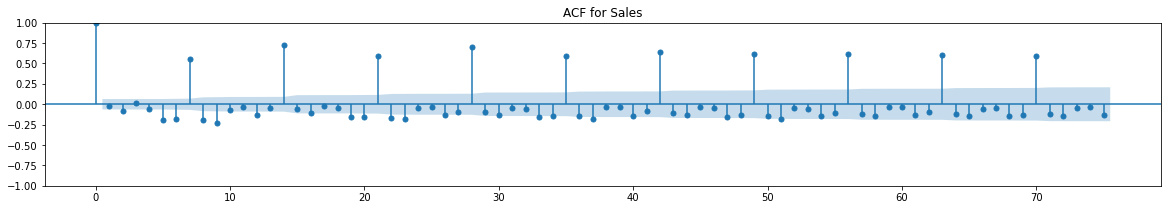

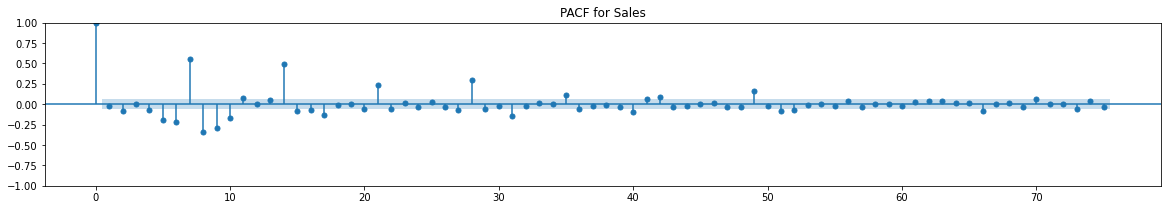

In [70]:
#Plotting ACF and PACF for sales
plot_acf_pacf(train_data_df_all['Sales'],'Sales')

* For ACF, we set q=0 as co-realation never comes down. 
* For PACF, we set q=7, since it is the highest lag since inception.

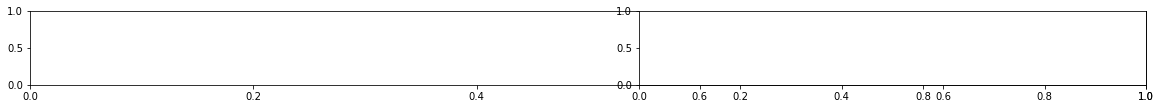

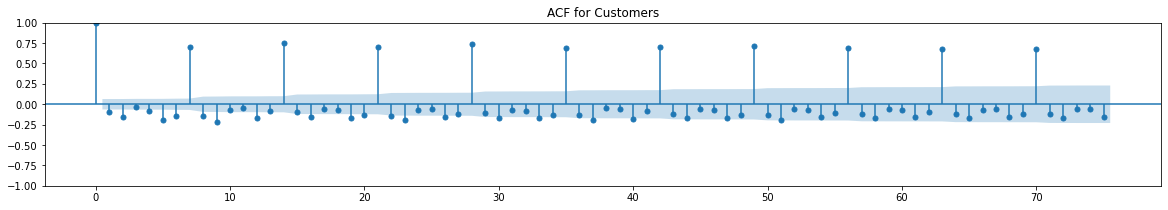

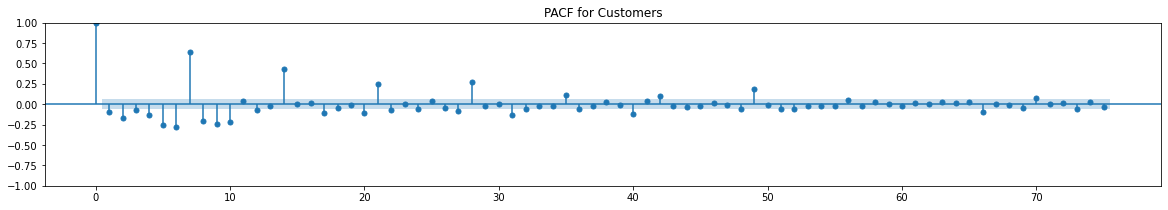

In [71]:
#Plotting ACF and PACF for Customers
plot_acf_pacf(train_data_df_all['Customers'],'Customers')

* For ACF, we set q=0 as co-realation never comes dowm. 
* For PACF, we set p=7, since it is the highest lag since inception.

# Train - Test Split

#### We need to predict sales for the next 6 weeks i.e 42 days. So, we keep 42 days for test and remaining for training.

In [72]:
train_data_df_all.shape

(942, 10)

In [73]:
#Creating train and test splits

# We will use first 900 rows for train and last 42 for test
train_len=900
train_data_df_all_train=train_data_df_all.iloc[:train_len,:]
train_data_df_all_test=train_data_df_all.iloc[train_len:,:]

In [74]:
train_data_df_all_train

,Sales,Customers,Promo,SchoolHoliday,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
Date,,,,,,,,,,
2013-01-01,87.284560,17.496409,0,1114,1.0,0.0,0.0,0.0,0.0,0.0
2013-01-02,6233.030493,748.049327,0,1115,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-03,5693.112108,682.547085,0,1040,0.0,0.0,1.0,0.0,0.0,0.0
2013-01-04,5954.218834,701.468161,0,1040,0.0,0.0,0.0,1.0,0.0,0.0
2013-01-05,5337.751570,616.566816,0,112,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2015-06-15,10376.771300,950.156951,1115,0,0.0,0.0,0.0,0.0,0.0,0.0
2015-06-16,8642.822422,841.740807,1115,0,1.0,0.0,0.0,0.0,0.0,0.0
2015-06-17,7729.576682,779.947982,1115,0,0.0,1.0,0.0,0.0,0.0,0.0


In [75]:
# Standardising numerical values in test-train datasets using minmax
# Fit transform on train data

scaler = MinMaxScaler()
train_data_df_all_train[['Sales','Customers','Promo','SchoolHoliday']]=scaler.fit_transform(train_data_df_all_train[['Sales','Customers','Promo','SchoolHoliday']])
train_data_df_all_train.head()

,Sales,Customers,Promo,SchoolHoliday,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
Date,,,,,,,,,,
2013-01-01,0.000000,0.000000,0.0,0.999103,1.0,0.0,0.0,0.0,0.0,0.0
2013-01-02,0.441350,0.543373,0.0,1.000000,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-03,0.402577,0.494654,0.0,0.932735,0.0,0.0,1.0,0.0,0.0,0.0
2013-01-04,0.421328,0.508727,0.0,0.932735,0.0,0.0,0.0,1.0,0.0,0.0
2013-01-05,0.377057,0.445579,0.0,0.100448,0.0,0.0,0.0,0.0,1.0,0.0


In [76]:
#Transform on test data
train_data_df_all_test[['Sales','Customers','Promo','SchoolHoliday']]=scaler.transform(train_data_df_all_test[['Sales','Customers','Promo','SchoolHoliday']])
train_data_df_all_test.head()

,Sales,Customers,Promo,SchoolHoliday,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
Date,,,,,,,,,,
2015-06-20,0.405336,0.453472,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2015-06-21,0.009824,0.015096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2015-06-22,0.415762,0.489576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-06-23,0.399006,0.475851,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2015-06-24,0.396755,0.474848,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# VAR [Vector AutoRegressive Model]

In [77]:
exog = train_data_df_all_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_data_df_all_train[['Sales', 'Customers']].astype(float)
var_model = sm.tsa.VAR(endog,exog)
res=var_model.select_order(maxlags=15)
print(res.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -12.15      -12.05   5.280e-06      -12.11
1       -12.27      -12.15   4.698e-06      -12.22
2       -12.27      -12.12   4.712e-06      -12.21
3       -12.30      -12.14   4.533e-06      -12.24
4       -12.31      -12.12   4.515e-06      -12.24
5       -12.31      -12.10   4.510e-06      -12.23
6       -12.32      -12.09   4.469e-06      -12.23
7       -12.32      -12.07   4.448e-06      -12.23
8       -12.48      -12.20   3.821e-06      -12.37
9       -12.51     -12.21*   3.707e-06      -12.39
10      -12.52      -12.21   3.648e-06      -12.40
11      -12.54      -12.20   3.581e-06      -12.41
12      -12.53      -12.18   3.604e-06      -12.40
13      -12.54      -12.16   3.574e-06      -12.40
14      -12.59      -12.19   3.421e-06     -12.43*
15     -12.59*      -12.17  3.395e-06*      -12.43
-------------------------------

C:\software\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


#### AIC is the lowest at lag 11.

In [78]:
#Fitting the model with lag 11
var_model_final = var_model.fit(11)
var_model_final.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 29, Mar, 2023
Time:                     10:07:51
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -12.2106
Nobs:                     889.000    HQIC:                  -12.4169
Log likelihood:           3115.22    FPE:                3.56415e-06
AIC:                     -12.5446    Det(Omega_mle):     3.32801e-06
--------------------------------------------------------------------
Results for equation Sales
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.337940         0.057254            5.902           0.000
Promo                 0.169451         0.016244           10.432           0.000
SchoolHoliday        -0.033177         0.012687           -2

## Cointegration test

In [79]:
def cointegration_test(df, lag): 
    alpha=0.05
    out = coint_johansen(df,-1,lag)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [80]:
train_data_df_all['Sales']=train_data_df_all['Sales'].apply(lambda x:round(x))
train_data_df_all['Customers']=train_data_df_all['Customers'].apply(lambda x:round(x))

In [81]:
cointegration_test(train_data_df_all[['Sales','Customers']],10)
rank_result=select_coint_rank(train_data_df_all[['Sales','Customers']],-1,10)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Sales  ::  127.93    > 12.3212   =>   True
Customers ::  6.57      > 4.1296    =>   True


In [82]:
print(rank_result.rank)

2


* We have the rank of Johassen test as 2 which means that the time series are stationary but do not seem to be co-integratied

In [83]:
# Getting lag order
lag_order = var_model_final.k_ar
print(lag_order) 
forecast_input = train_data_df_all_train[['Sales','Customers']].values[-lag_order:]
forecast_input

11


array([[0.43595062, 0.50832754],
       [0.41397174, 0.4892133 ],
       [0.41579704, 0.49799996],
       [0.41923316, 0.49742961],
       [0.41303913, 0.45743139],
       [0.0110916 , 0.01718541],
       [0.73892895, 0.69369782],
       [0.61440719, 0.61305964],
       [0.54882338, 0.56709914],
       [0.5213138 , 0.5473912 ],
       [0.53850368, 0.5678536 ]])

## Forecasting using VAR

In [84]:
exog_test = train_data_df_all_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
fc = var_model_final.forecast(y=forecast_input, steps=42,exog_future=exog_test)
var_forecast = pd.DataFrame(fc, index=train_data_df_all_test.index, columns=['Sales','Customers'])
var_forecast

,Sales,Customers
Date,,
2015-06-20,0.441004,0.500055
2015-06-21,0.015879,0.013267
2015-06-22,0.427535,0.508562
2015-06-23,0.414973,0.506646
2015-06-24,0.377980,0.462299
2015-06-25,0.343401,0.426233
2015-06-26,0.434158,0.515352
2015-06-27,0.419477,0.473930
2015-06-28,0.021367,0.018221


In [85]:
#Adding forecasted values
train_data_df_all_test['VarForecastedSales']=var_forecast.Sales
train_data_df_all_test['VarForecastedCustomers']=var_forecast.Customers

In [86]:
#Creating a function for results visualization
def forecasted_timeseries_visualization(series,forecasted_series,c,model):
    fig = plt.figure(figsize=(20, 3))
    series.plot(label='Actual')
    forecasted_series.plot(label='Forecasted')
    plt.xlabel('Date')
    plt.ylabel(c)
    plt.legend(loc='best')
    plt.title('{} model For {}'.format(model,c))
    plt.show()

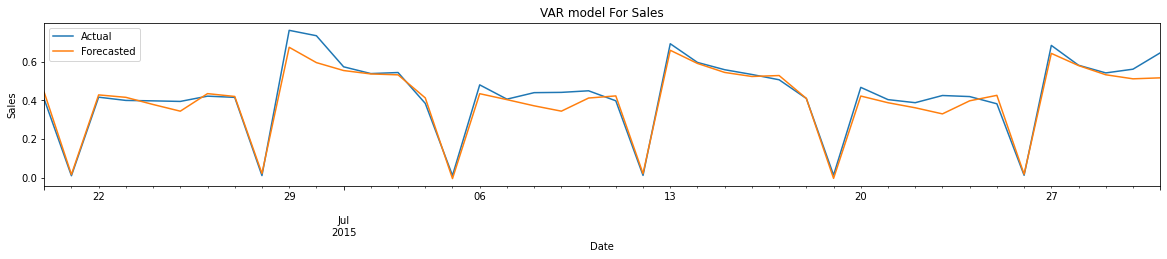

In [87]:
forecasted_timeseries_visualization(train_data_df_all_test['Sales'],train_data_df_all_test['VarForecastedSales'],'Sales','VAR')

In [88]:
# Storing results in a dataframe
summary_df=pd.DataFrame(columns=['Store','Model','RMSE_SALES','MAPE_SALES','RMSE_CUSTOMERS','MAPE_CUSTOMERS'])

def summary(s,fs,c,fc,store,model):
    rmse_sales = np.sqrt(mean_squared_error(s, fs)).round(2)
    mape_sales = np.round(np.mean(np.abs(s-fs)/s)*100,2)
    rmse_customers = np.sqrt(mean_squared_error(c, fc)).round(2)
    mape_customers = np.round(np.mean(np.abs(c-fc)/c)*100,2)
    temp=pd.DataFrame({'Store':[store],'Model':[model], 'RMSE_SALES': [rmse_sales],'MAPE_SALES': [mape_sales] , 
                            'RMSE_CUSTOMERS': [rmse_customers],'MAPE_CUSTOMERS': [mape_customers]})
    return temp

In [89]:
d=summary(train_data_df_all_test['Sales'], train_data_df_all_test['VarForecastedSales'],
       train_data_df_all_test['Customers'], train_data_df_all_test['VarForecastedCustomers'],'All','VAR')
summary_df = pd.concat([summary_df, d])
summary_df.head()

,Store,Model,RMSE_SALES,MAPE_SALES,RMSE_CUSTOMERS,MAPE_CUSTOMERS
0,All,VAR,0.05,19.37,0.03,9.1


## Forecasting using VARMAX

#### We had used q=0 and p=7 for VAR

In [90]:
#modelling

exog = train_data_df_all_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_data_df_all_train[['Sales', 'Customers']].astype(float)
varmax_model = sm.tsa.VARMAX(endog, order=(7,0),  exog=exog)
varmax_model_fit = varmax_model.fit(maxiter=1000, disp=False)
print(varmax_model_fit.summary())

C:\software\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\software\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  900
Model:                            VARX(7)   Log Likelihood                3029.424
                              + intercept   AIC                          -5960.847
Date:                    Wed, 29 Mar 2023   BIC                          -5725.530
Time:                            10:09:17   HQIC                         -5870.954
Sample:                        01-01-2013                                         
                             - 06-19-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            1.17, 39.12   Jarque-Bera (JB):     5637.63, 1854.32
Prob(Q):                        0.28, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.61, 1.50   Skew:                     -1.78, -1.51
P

In [91]:
#forecasting on test data
exog_test = train_data_df_all_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog_test= train_data_df_all_test[['Sales','Customers']]
varmax_fc = varmax_model_fit.predict(start=train_data_df_all_test.index.min(),end=train_data_df_all_test.index.max(),exog=exog_test)
varmax_forecast = pd.DataFrame(varmax_fc, index=train_data_df_all_test.index, columns=['Sales','Customers'])
varmax_forecast.head()

,Sales,Customers
Date,,
2015-06-20,0.440813,0.500234
2015-06-21,0.011718,0.009987
2015-06-22,0.462946,0.528924
2015-06-23,0.405953,0.498269
2015-06-24,0.363518,0.459523


In [92]:
#Adding forecasted values
train_data_df_all_test['VarmaxForecastedSales']=varmax_forecast.Sales
train_data_df_all_test['VarmaxForecastedCustomers']=varmax_forecast.Customers

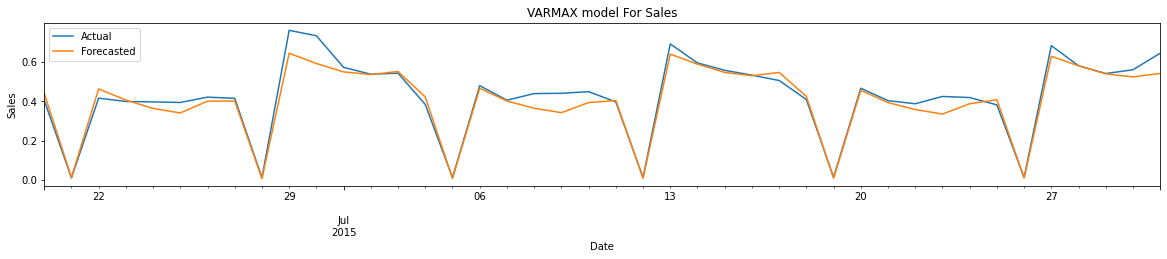

In [93]:
#Plotting time series
forecasted_timeseries_visualization(train_data_df_all_test['Sales'],train_data_df_all_test['VarmaxForecastedSales'],'Sales','VARMAX')

In [94]:
#Printing results
d=summary(train_data_df_all_test['Sales'], train_data_df_all_test['VarmaxForecastedSales'],
       train_data_df_all_test['Customers'], train_data_df_all_test['VarmaxForecastedCustomers'],'All','VARMAX')
summary_df = pd.concat([summary_df, d])
summary_df.head()

,Store,Model,RMSE_SALES,MAPE_SALES,RMSE_CUSTOMERS,MAPE_CUSTOMERS
0,All,VAR,0.05,19.37,0.03,9.10
0,All,VARMAX,0.05,10.69,0.03,8.73


# Forecasting sales for store 1,3,8,9,13,25,29,31 and 46

### Lets consider store 1 only first

In [95]:
train_data_df_store_1 = train_data_df[train_data_df['Store'] == 1]

In [96]:
train_data_df_store_1.head(5).append(train_data_df_store_1.tail(5))

,Store,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,PromoInterval,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c
Date,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5263,555,1,1,0,1,1270.0,0,0,0,0,1,0,0,0,1,0,0,0
2015-07-30,1,5020,546,1,1,0,1,1270.0,0,0,0,1,0,0,0,0,1,0,0,0
2015-07-29,1,4782,523,1,1,0,1,1270.0,0,0,1,0,0,0,0,0,1,0,0,0
2015-07-28,1,5011,560,1,1,0,1,1270.0,0,1,0,0,0,0,0,0,1,0,0,0
2015-07-27,1,6102,612,1,1,0,1,1270.0,0,0,0,0,0,0,0,0,1,0,0,0
2013-01-05,1,4997,635,1,0,0,1,1270.0,0,0,0,0,0,1,0,0,1,0,0,0
2013-01-04,1,4486,619,1,0,0,1,1270.0,0,0,0,0,1,0,0,0,1,0,0,0
2013-01-03,1,4327,578,1,0,0,1,1270.0,0,0,0,1,0,0,0,0,1,0,0,0
2013-01-02,1,5530,668,1,0,0,1,1270.0,0,0,1,0,0,0,0,0,1,0,0,0


In [97]:
train_data_df_store_1 = train_data_df_store_1.sort_index(ascending=True)

In [98]:
train_data_df_store_1.head(5).append(train_data_df_store_1.tail(5))

,Store,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,PromoInterval,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c
Date,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,0,0,0,0,a,1,1270.0,0,1,0,0,0,0,0,0,1,0,0,0
2013-01-02,1,5530,668,1,0,0,1,1270.0,0,0,1,0,0,0,0,0,1,0,0,0
2013-01-03,1,4327,578,1,0,0,1,1270.0,0,0,0,1,0,0,0,0,1,0,0,0
2013-01-04,1,4486,619,1,0,0,1,1270.0,0,0,0,0,1,0,0,0,1,0,0,0
2013-01-05,1,4997,635,1,0,0,1,1270.0,0,0,0,0,0,1,0,0,1,0,0,0
2015-07-27,1,6102,612,1,1,0,1,1270.0,0,0,0,0,0,0,0,0,1,0,0,0
2015-07-28,1,5011,560,1,1,0,1,1270.0,0,1,0,0,0,0,0,0,1,0,0,0
2015-07-29,1,4782,523,1,1,0,1,1270.0,0,0,1,0,0,0,0,0,1,0,0,0
2015-07-30,1,5020,546,1,1,0,1,1270.0,0,0,0,1,0,0,0,0,1,0,0,0


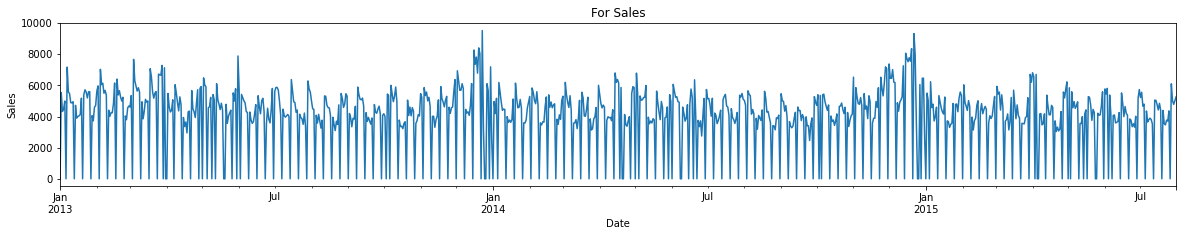

In [99]:
# Plotting time series chart for Sales
timeseries_plot(train_data_df_store_1['Sales'], 'Sales')

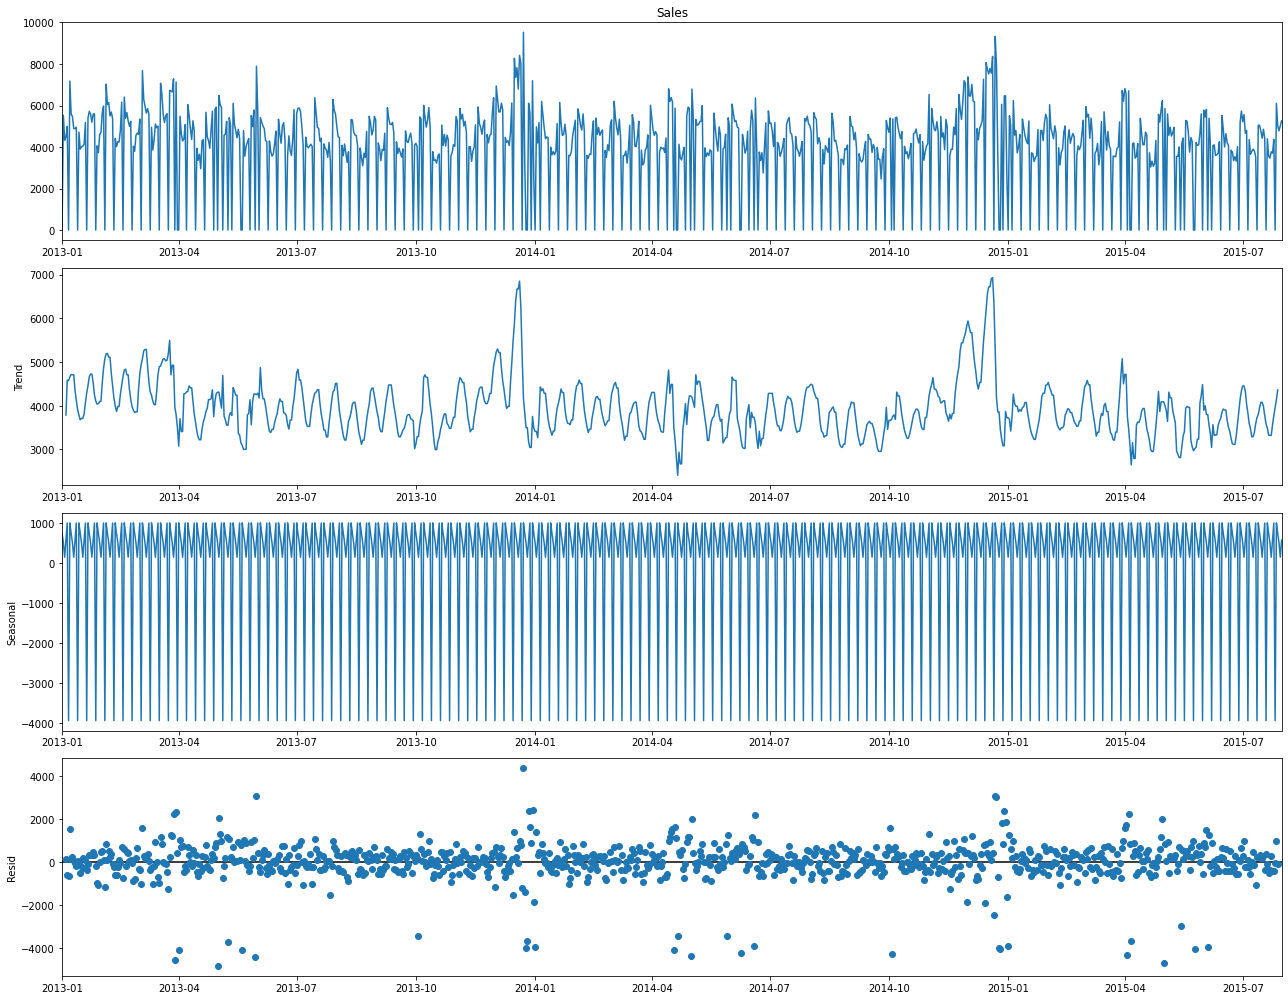

Mean Residual for Sales=0.2284083648050237


In [100]:
# Seasonal decomposition
plot_seasonal_decomposition(train_data_df_store_1['Sales'], 'Sales', 'additive')

In [101]:
# Stationary test
stationary_test(train_data_df_store_1[['Sales','Customers']])

For  Sales
****************************************************************************************************
ADF Statistic= -4.368104368168502
P value= 0.0003378834614142396
 => P-Value = 0.0003. Rejecting Null Hypothesis.
 => Series is Stationary.
For  Customers
****************************************************************************************************
ADF Statistic= -3.6968421117345343
P value= 0.004157792561711119
 => P-Value = 0.0042. Rejecting Null Hypothesis.
 => Series is Stationary.


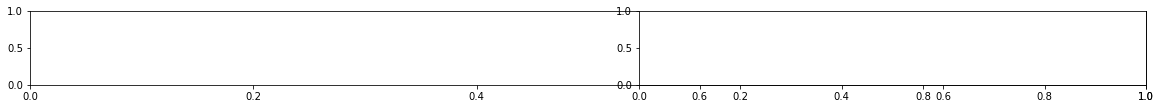

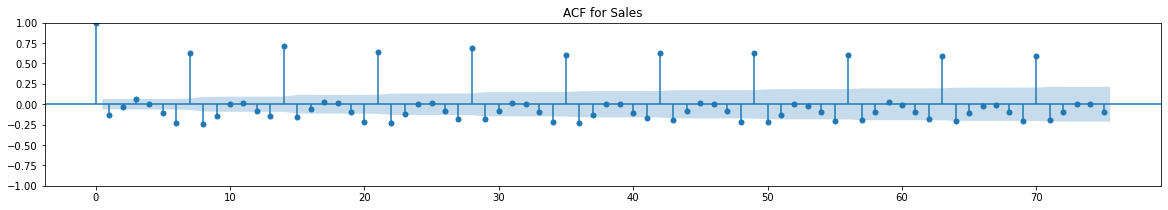

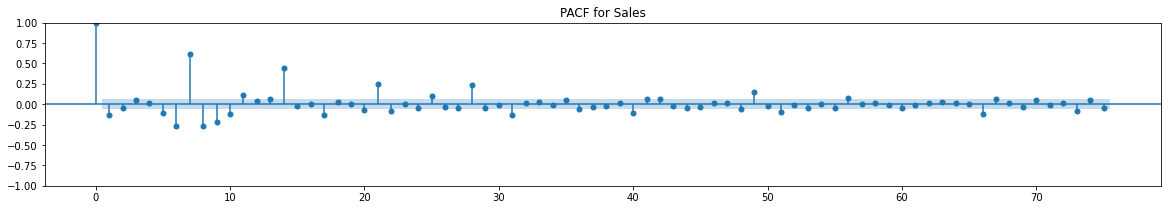

In [102]:
#Plotting ACF and PACF for sales
plot_acf_pacf(train_data_df_store_1['Sales'],'Sales')

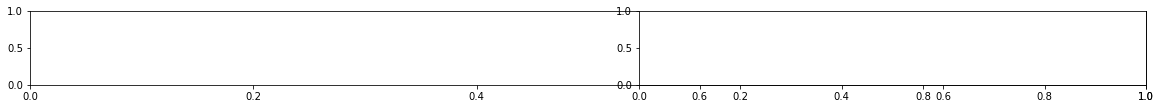

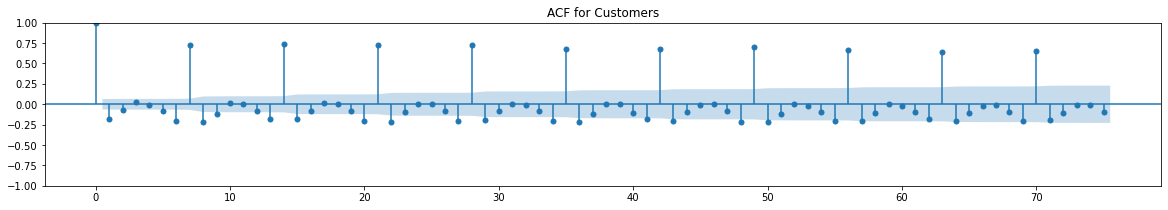

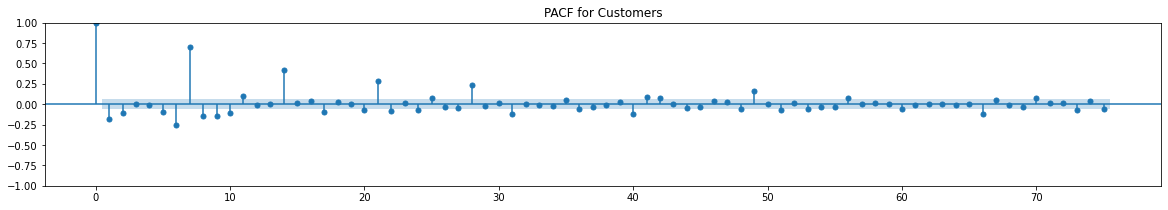

In [103]:
#Plotting ACF and PACF for Customers
plot_acf_pacf(train_data_df_store_1['Customers'],'Customers')

In [104]:
# Train - Test Split
train_data_df_store_1_train=train_data_df_store_1.iloc[:train_len,:]
train_data_df_store_1_test=train_data_df_store_1.iloc[train_len:,:]

In [105]:
#Standardising numerical values in test-train datasets using minmax
train_data_df_store_1_train[['Sales','Customers','Promo','SchoolHoliday']]=scaler.fit_transform(train_data_df_store_1_train[['Sales','Customers','Promo','SchoolHoliday']])

In [106]:
train_data_df_store_1_test[['Sales','Customers','Promo','SchoolHoliday']]=scaler.transform(train_data_df_store_1_test[['Sales','Customers','Promo','SchoolHoliday']])

In [107]:
#VAR [Vector AutoRegressive Model]
exog = train_data_df_store_1_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_data_df_store_1_train[['Sales', 'Customers']].astype(float)
var_model = sm.tsa.VAR(endog,exog)
res=var_model.select_order(maxlags=15)
print(res.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -11.69      -11.59   8.362e-06      -11.65
1       -11.76     -11.64*   7.841e-06      -11.71
2       -11.76      -11.62   7.781e-06      -11.71
3       -11.77      -11.61   7.701e-06      -11.71
4       -11.77      -11.59   7.719e-06      -11.70
5       -11.78      -11.57   7.673e-06      -11.70
6       -11.79      -11.56   7.580e-06      -11.70
7       -11.80      -11.55   7.484e-06      -11.71
8       -11.81      -11.54   7.464e-06      -11.70
9       -11.81      -11.52   7.440e-06      -11.70
10      -11.84      -11.52   7.235e-06     -11.72*
11     -11.84*      -11.50  7.232e-06*      -11.71
12      -11.83      -11.48   7.260e-06      -11.70
13      -11.84      -11.46   7.241e-06      -11.69
14      -11.83      -11.43   7.257e-06      -11.68
15      -11.83      -11.41   7.273e-06      -11.67
-------------------------------

C:\software\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [108]:
#Fitting the model with lag 11
var_model_final = var_model.fit(11)
var_model_final.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 29, Mar, 2023
Time:                     10:09:20
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -11.5080
Nobs:                     889.000    HQIC:                  -11.7144
Log likelihood:           2802.92    FPE:                7.19592e-06
AIC:                     -11.8421    Det(Omega_mle):     6.71915e-06
--------------------------------------------------------------------
Results for equation Sales
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.167925         0.040619            4.134           0.000
Promo                 0.151064         0.014433           10.467           0.000
SchoolHoliday        -0.024792         0.009326           -2

In [109]:
#Cointegration test
train_data_df_store_1['Sales']=train_data_df_store_1['Sales'].apply(lambda x:round(x))
train_data_df_store_1['Customers']=train_data_df_store_1['Customers'].apply(lambda x:round(x))

cointegration_test(train_data_df_store_1[['Sales','Customers']],10)
rank_result=select_coint_rank(train_data_df_store_1[['Sales','Customers']],-1,10)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Sales  ::  80.0      > 12.3212   =>   True
Customers ::  0.73      > 4.1296    =>   False


In [110]:
print(rank_result.rank)

1


In [111]:
# Getting lag order
lag_order = var_model_final.k_ar
print(lag_order) 
forecast_input = train_data_df_store_1_train[['Sales','Customers']].values[-lag_order:]
forecast_input

11


array([[0.43052057, 0.42920354],
       [0.37688917, 0.40088496],
       [0.38066751, 0.39115044],
       [0.38780437, 0.37345133],
       [0.44668346, 0.44424779],
       [0.        , 0.        ],
       [0.57913518, 0.51858407],
       [0.50923594, 0.44513274],
       [0.41981528, 0.42123894],
       [0.4875105 , 0.44070796],
       [0.44101595, 0.43097345]])

In [112]:
# Forecasting using VAR
exog_test = train_data_df_store_1_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
fc = var_model_final.forecast(y=forecast_input, steps=42,exog_future=exog_test)
var_forecast = pd.DataFrame(fc, index=train_data_df_store_1_test.index, columns=['Sales','Customers'])
var_forecast.head()

,Sales,Customers
Date,,
2015-06-20,0.492641,0.497172
2015-06-21,-0.006503,-0.012087
2015-06-22,0.390253,0.403236
2015-06-23,0.387824,0.412654
2015-06-24,0.359809,0.392580


In [113]:
#Adding forecasted values
train_data_df_store_1_test['VarForecastedSales']=var_forecast.Sales
train_data_df_store_1_test['VarForecastedCustomers']=var_forecast.Customers

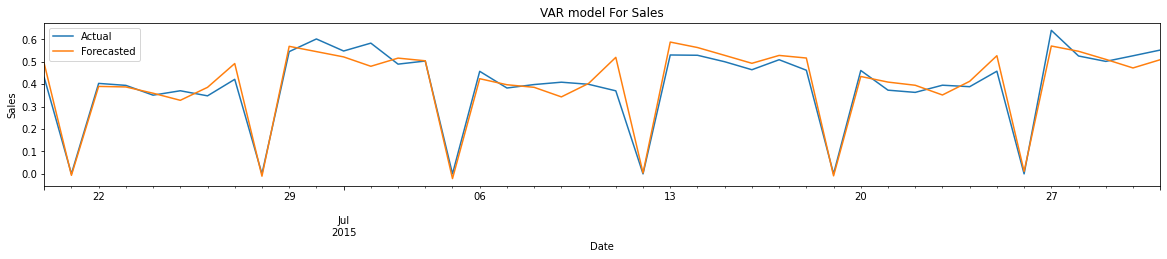

In [114]:
# Creating a function for results visualization
forecasted_timeseries_visualization(train_data_df_store_1_test['Sales'],train_data_df_store_1_test['VarForecastedSales'],'Sales','VAR')

In [115]:
# Forecasting using VARMAX
exog = train_data_df_store_1_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_data_df_store_1_train[['Sales', 'Customers']].astype(float)
varmax_model = sm.tsa.VARMAX(endog, order=(7,0),  exog=exog)
varmax_model_fit = varmax_model.fit(maxiter=1000, disp=False)
print(varmax_model_fit.summary())

C:\software\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  900
Model:                            VARX(7)   Log Likelihood                2795.435
                              + intercept   AIC                          -5492.871
Date:                    Wed, 29 Mar 2023   BIC                          -5257.554
Time:                            10:10:24   HQIC                         -5402.978
Sample:                        01-01-2013                                         
                             - 06-19-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             0.59, 2.57   Jarque-Bera (JB):       3764.66, 44.62
Prob(Q):                        0.44, 0.11   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.40, 1.06   Skew:                     -1.73, -0.22
P

In [116]:
# forecasting on test data
exog_test = train_data_df_store_1_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog_test= train_data_df_store_1_test[['Sales','Customers']]
varmax_fc = varmax_model_fit.predict(start=train_data_df_store_1_test.index.min(),end=train_data_df_store_1_test.index.max(),exog=exog_test)
varmax_forecast = pd.DataFrame(varmax_fc, index=train_data_df_store_1_test.index, columns=['Sales','Customers'])
varmax_forecast.head()

,Sales,Customers
Date,,
2015-06-20,0.496335,0.499489
2015-06-21,-0.007112,-0.010956
2015-06-22,0.406961,0.417949
2015-06-23,0.405314,0.427984
2015-06-24,0.359210,0.393011


In [117]:
# Adding forecasted values
train_data_df_store_1_test['VarmaxForecastedSales']=varmax_forecast.Sales
train_data_df_store_1_test['VarmaxForecastedCustomers']=varmax_forecast.Customers

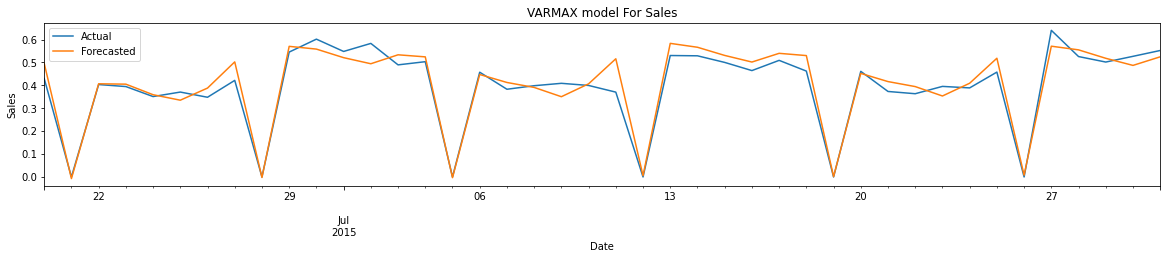

In [118]:
#Plotting time series
forecasted_timeseries_visualization(train_data_df_store_1_test['Sales'],train_data_df_store_1_test['VarmaxForecastedSales'],'Sales','VARMAX')

In [119]:
train_data_df_store_1_test[['Sales', 'Customers', 'VarForecastedSales', 'VarForecastedCustomers', 'VarmaxForecastedSales','VarmaxForecastedCustomers']]

,Sales,Customers,VarForecastedSales,VarForecastedCustomers,VarmaxForecastedSales,VarmaxForecastedCustomers
Date,,,,,,
2015-06-20,0.429996,0.437168,0.492641,0.497172,0.496335,0.499489
2015-06-21,0.000000,0.000000,-0.006503,-0.012087,-0.007112,-0.010956
2015-06-22,0.403652,0.432743,0.390253,0.403236,0.406961,0.417949
2015-06-23,0.394836,0.395575,0.387824,0.412654,0.405314,0.427984
2015-06-24,0.351175,0.366372,0.359809,0.392580,0.359210,0.393011
2015-06-25,0.370802,0.383186,0.328213,0.364188,0.335282,0.374262
2015-06-26,0.348132,0.371681,0.386100,0.416534,0.388242,0.421284
2015-06-27,0.421809,0.409735,0.492297,0.505340,0.502602,0.517799
2015-06-28,0.000000,0.000000,-0.010296,-0.012917,-0.002238,-0.001534


## Forecasting for all the stores using single function

In [120]:
scaler = MinMaxScaler()

# Function to impute missing values for storeId 13 and 46
def impute_missing_values(train_data_df_store, storeId):
    # Add missing timestamp in series
    train_data_df_store = train_data_df_store.reindex(pd.date_range('2013-01-01', '2015-07-31'))
    # Get values for missing timestamp from last year as values are not increasing and are in range
    temp = train_data_df_store.loc['2013-07-01':'2013-12-31']
    # Generate date values for missing range (2014-07-01 - 2014-12-31)
    temp['new_index'] = pd.date_range("2014-07-01", periods=184, freq="D")
    # Change index for temp df as we need to replace values of train_data_df_store df with temp df
    temp.set_index('new_index',inplace=True)
    # Update calues of original train_data_df_store with temp df for missing timeframe
    train_data_df_store.update(temp)
    return train_data_df_store
    

# Lets write common function which will predict values for all the required stores
def forcast_for_selected_store(store_ids):
    train_len = 900
    result = pd.DataFrame()
  
    for storeId in store_ids:
        print("Start forecasting for store: ", storeId)
        # Selecting data for specific store
        train_data_df_store = train_data_df[train_data_df['Store'] == storeId]
        #print(train_data_df_store.shape)
        #print(train_data_df_store.head())
        
        # Order store data in ascending order of date
        train_data_df_store = train_data_df_store.sort_index(ascending=True)
        #print(train_data_df_store.head())
        
        if storeId in (13, 46):
            train_data_df_store = impute_missing_values(train_data_df_store, storeId)
        
        train_data_df_store_train=train_data_df_store.iloc[:train_len,:]
        train_data_df_store_test=train_data_df_store.iloc[train_len:,:]
        
        #Standardising numerical values in test-train datasets using minmax
        train_data_df_store_train[['Sales','Customers','Promo','SchoolHoliday']]=scaler.fit_transform(train_data_df_store_train[['Sales','Customers','Promo','SchoolHoliday']])
        train_data_df_store_test[['Sales','Customers','Promo','SchoolHoliday']]=scaler.transform(train_data_df_store_test[['Sales','Customers','Promo','SchoolHoliday']])
        
        # Forecasting using VARMAX
        exog = train_data_df_store_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
        endog = train_data_df_store_train[['Sales', 'Customers']].astype(float)
        varmax_model = sm.tsa.VARMAX(endog, order=(7,0),  exog=exog)
        varmax_model_fit = varmax_model.fit(maxiter=1000, disp=False)
        
        # forecasting on test data
        exog_test = train_data_df_store_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
        endog_test= train_data_df_store_test[['Sales','Customers']]
        varmax_fc = varmax_model_fit.predict(start=train_data_df_store_test.index.min(),end=train_data_df_store_test.index.max(),exog=exog_test)
        varmax_forecast = pd.DataFrame(varmax_fc, index=train_data_df_store_1_test.index, columns=['Sales','Customers'])
        
        # Adding forecasted values
        salesColName = 'SalesStore_' + str(storeId)
        customersColName = 'CustomersStore_' + str(storeId)
        forecatedSalesColName = 'VarmaxForecastedSalesStore_' + str(storeId)
        forecatedCustomersColName = 'VarmaxForecastedCustomersStore_' + str(storeId)
        #print(salesColName, customersColName, forecatedSalesColName, forecatedCustomersColName)
        
        # Inverse transform train_data_df_store_test
        train_data_df_store_test[['Sales','Customers','Promo','SchoolHoliday']] = scaler.inverse_transform(train_data_df_store_test[['Sales','Customers','Promo','SchoolHoliday']])
        result[salesColName] = train_data_df_store_test['Sales']
        result[customersColName] = train_data_df_store_test['Customers']
        
        varmax_forecast[['Promo','SchoolHoliday']] = train_data_df_store_test[['Promo','SchoolHoliday']]
        # Inverse transform varmax_forecast
        varmax_forecast_inversed = scaler.inverse_transform(varmax_forecast)
        # Create dataframe from array
        varmax_forecast_inversed_df = pd.DataFrame(varmax_forecast_inversed, index=varmax_forecast.index, columns=['Sales','Customers','Promo','SchoolHoliday'])
        result[forecatedSalesColName] = varmax_forecast_inversed_df.Sales
        result[forecatedCustomersColName] = varmax_forecast_inversed_df.Customers
        
        # Results visualization
        graphName = 'Store ' + str(storeId)
        forecasted_timeseries_visualization(result[salesColName], result[forecatedSalesColName], graphName,'VARMAX')
        
        print("Finished forecasting for store: ", storeId)

    return result

Start forecasting for store:  1


C:\software\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


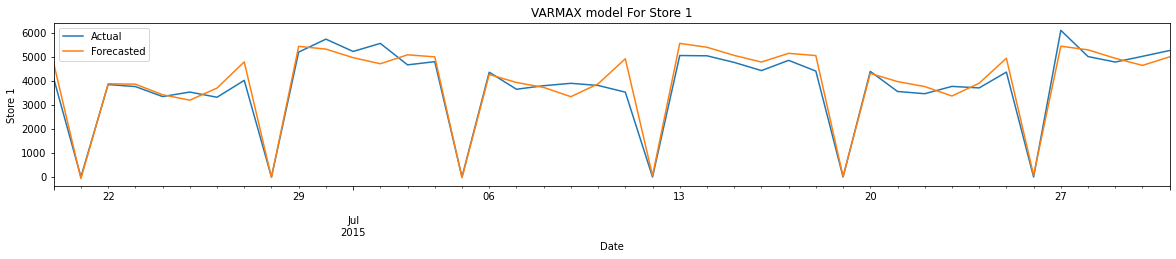

Finished forecasting for store:  1
Start forecasting for store:  3


C:\software\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


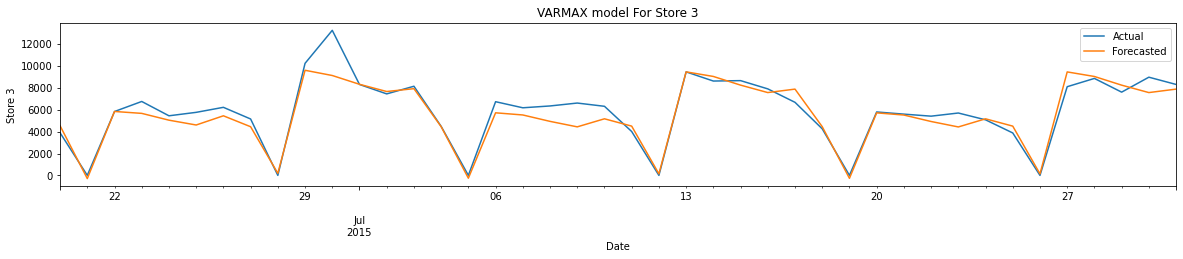

Finished forecasting for store:  3
Start forecasting for store:  8


C:\software\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


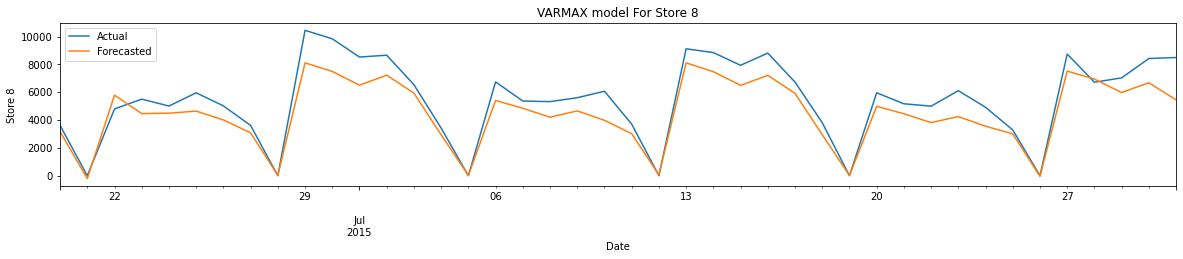

Finished forecasting for store:  8
Start forecasting for store:  9


C:\software\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


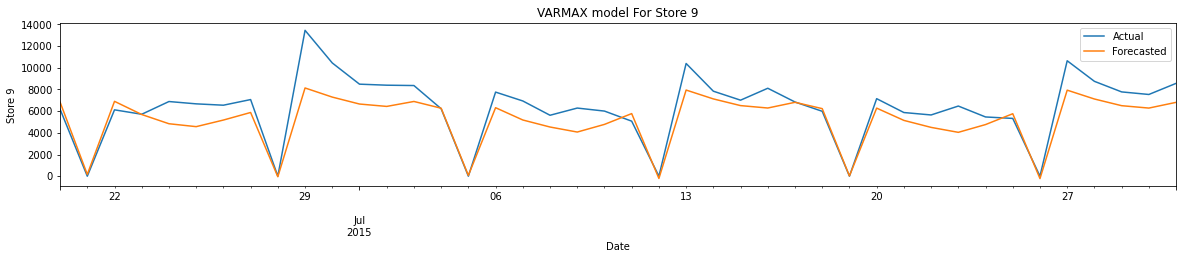

Finished forecasting for store:  9
Start forecasting for store:  13


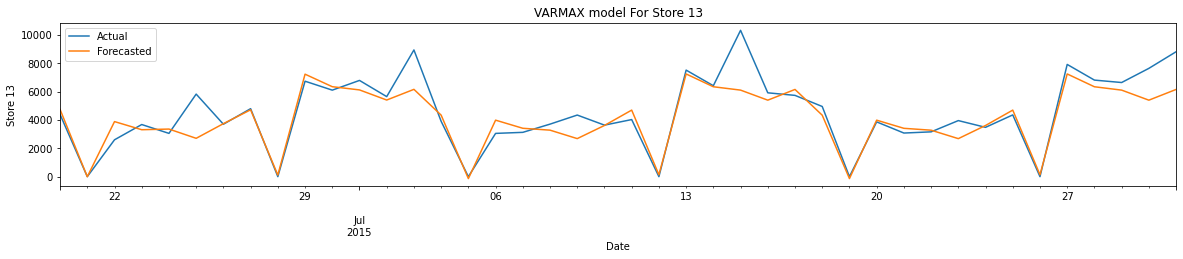

Finished forecasting for store:  13
Start forecasting for store:  25


C:\software\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\software\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


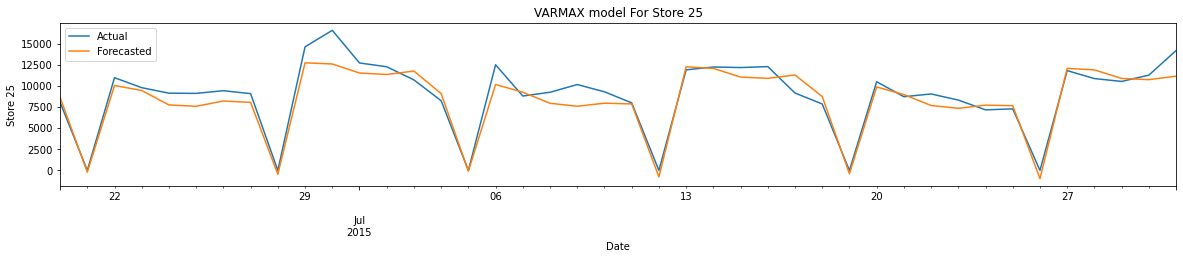

Finished forecasting for store:  25
Start forecasting for store:  29


C:\software\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\software\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


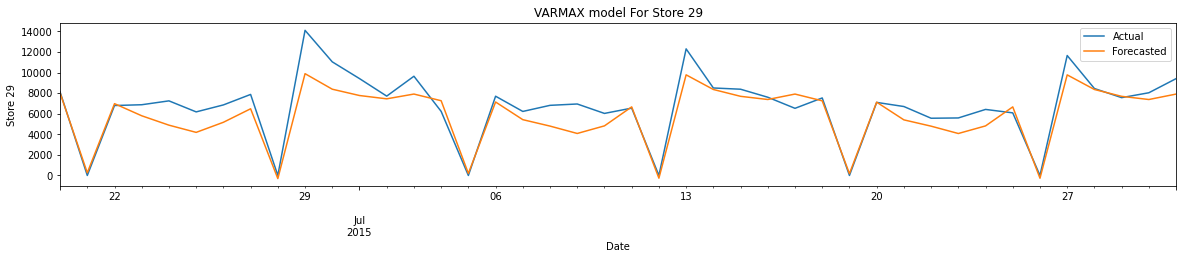

Finished forecasting for store:  29
Start forecasting for store:  31


C:\software\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


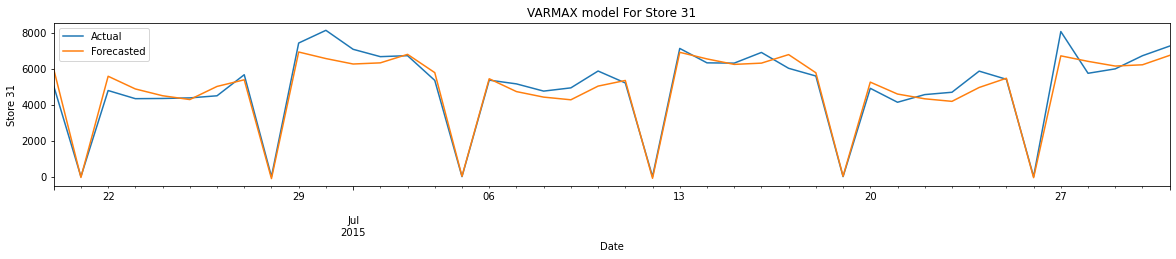

Finished forecasting for store:  31
Start forecasting for store:  46


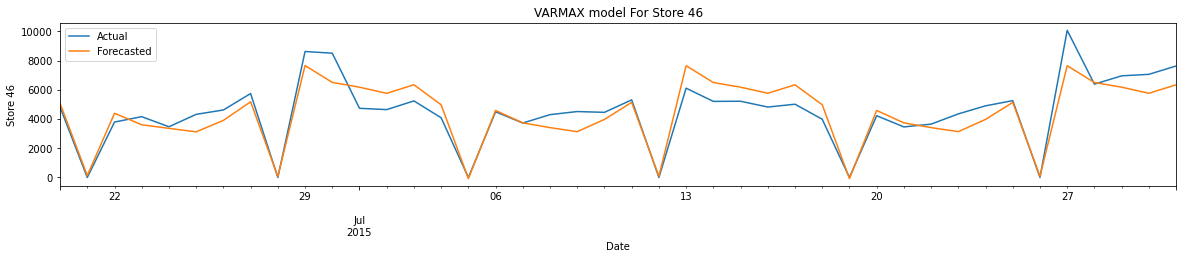

Finished forecasting for store:  46


In [121]:
store_ids = [1, 3, 8, 9, 13, 25, 29, 31, 46]

result = forcast_for_selected_store(store_ids)

In [122]:
result.head()

,SalesStore_1,CustomersStore_1,VarmaxForecastedSalesStore_1,VarmaxForecastedCustomersStore_1,SalesStore_3,CustomersStore_3,VarmaxForecastedSalesStore_3,VarmaxForecastedCustomersStore_3,SalesStore_8,CustomersStore_8,...,VarmaxForecastedSalesStore_29,VarmaxForecastedCustomersStore_29,SalesStore_31,CustomersStore_31,VarmaxForecastedSalesStore_31,VarmaxForecastedCustomersStore_31,SalesStore_46,CustomersStore_46,VarmaxForecastedSalesStore_46,VarmaxForecastedCustomersStore_46
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-20,4097.0,494.0,4729.082261,564.423070,3891.0,424.0,4534.206060,529.381248,3611.0,409.0,...,8015.145285,715.019882,5032.0,528.0,5970.749277,617.839953,4812.0,665.0,5068.468848,689.527900
2015-06-21,0.0,0.0,-67.760623,-12.380297,0.0,0.0,-293.012881,-23.475253,0.0,0.0,...,257.348743,5.709710,0.0,0.0,-45.894392,-10.557176,0.0,0.0,130.383531,14.607075
2015-06-22,3846.0,489.0,3877.520801,472.282057,5840.0,638.0,5843.384728,695.091913,4796.0,630.0,...,6978.695406,621.621924,4779.0,476.0,5571.298830,564.595796,3792.0,528.0,4392.207195,569.917444
2015-06-23,3762.0,447.0,3861.830821,483.621767,6757.0,779.0,5668.999134,713.770120,5501.0,759.0,...,5800.991415,559.612499,4327.0,438.0,4866.499372,507.304060,4160.0,536.0,3604.514307,516.165766
2015-06-24,3346.0,414.0,3422.550604,444.102636,5448.0,633.0,5047.058332,642.689256,5005.0,625.0,...,4888.614218,486.481228,4338.0,485.0,4489.940161,486.136312,3469.0,511.0,3359.972947,491.392577
